In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
import tqdm
np.set_printoptions(precision=4)

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import LambdaLR
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import torch.nn.functional as F
from einops import rearrange, reduce
import pytorch_warmup as warmup

from gpt_adaln_core import Transformer
# from gpt_core import Transformer, EMA

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

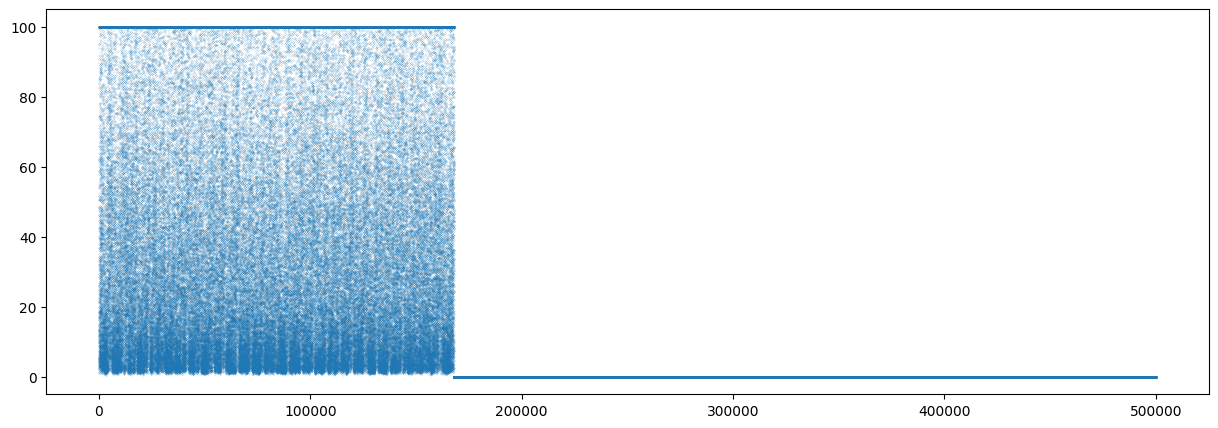

In [3]:
replay_buffer = pkl.load(open('../../data/replay_buffer_mixed_obj.pkl', 'rb'))

plt.figure(figsize=(15, 5))
plt.plot(replay_buffer['rew'], 'o' ,markersize=0.11)

In [4]:
rb_pos_world = np.zeros((8,8,2))
kdtree_positions_world = np.zeros((64, 2))
for i in range(8):
    for j in range(8):
        if i%2!=0:
            finger_pos = np.array((i*0.0375, j*0.043301 - 0.02165))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301 - 0.02165))
        else:
            finger_pos = np.array((i*0.0375, j*0.043301))
            rb_pos_world[i,j] = np.array((i*0.0375, j*0.043301))
        kdtree_positions_world[i*8 + j, :] = rb_pos_world[i,j]

np.min(kdtree_positions_world, axis=0), np.max(kdtree_positions_world, axis=0)

(array([ 0.    , -0.0216]), array([0.2625, 0.3031]))

In [5]:
import numpy as np
import pickle as pkl
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import torch

class ImitationDataset(Dataset):
    def __init__(self, states, actions, next_states, pos, num_agents, rewards, done):
        self.states = states
        self.actions = actions
        self.next_states = next_states
        self.pos = pos
        self.num_agents = num_agents
        self.rewards = rewards
        self.done = done

    def __len__(self):
        return len(self.states)

    def __getitem__(self, idx):
        state = self.states[idx]
        action = self.actions[idx]
        next_states = self.next_states[idx]
        pos = self.pos[idx]
        num_agents = self.num_agents[idx]
        reward = self.rewards[idx]
        done = self.done[idx]
        return state, action, next_states, pos, reward, done, num_agents

def get_smol_dataset(states, actions, next_states, pos, num_agents, rewards, done, num_samples:int=None):
    if num_samples is None:
        return ImitationDataset(states, actions, next_states, pos, num_agents, rewards, done)
        
    chosen_indices = np.random.choice(np.arange(len(states)), num_samples, replace=False)
    final_indices = np.array(chosen_indices)

    smol_states = states[final_indices]
    smol_actions = actions[final_indices]
    smol_next_states = next_states[final_indices]
    smol_pos = pos[final_indices]
    smol_num_agents = num_agents[final_indices]
    smol_rewards = rewards[final_indices]
    smol_done = done[final_indices]
    return ImitationDataset(smol_states, smol_actions, smol_next_states, smol_pos, smol_num_agents, smol_rewards, smol_done)

def split_dataset(dataset, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    dataset_size = len(dataset)
    indices = list(range(dataset_size))
    train_size = int(train_ratio * dataset_size)
    val_size = int(val_ratio * dataset_size)
    # test size is the remainder

    np.random.shuffle(indices)
    
    train_indices = indices[:train_size]
    val_indices = indices[train_size:train_size+val_size]
    test_indices = indices[train_size+val_size:]

    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset

def get_dataset_and_dataloaders(
    train_bs:int=128,
    val_bs:int=128,
    test_bs:int=1,
    actor_num_samples=1000,
    critic_num_samples=10000,
    rb_path='../../data/replay_buffer_mixed.pkl'
):
    replay_buffer = pkl.load(open(rb_path, 'rb'))

    obs = replay_buffer['obs']
    act = replay_buffer['act']
    obs2 = replay_buffer['obs2']
    pos = replay_buffer['pos']
    num_agents = replay_buffer['num_agents']
    rewards = replay_buffer['rew']
    done = replay_buffer['done']

    # Actor: only actions with rewards > 30
    actor_idxs = np.where(rewards > 30)[0]
    actor_dataset = get_smol_dataset(
        obs[actor_idxs], act[actor_idxs], obs2[actor_idxs],
        pos[actor_idxs], num_agents[actor_idxs],
        rewards[actor_idxs], done[actor_idxs],
        num_samples=actor_num_samples
    )

    # Split actor dataset
    actor_train_dataset, actor_val_dataset, actor_test_dataset = split_dataset(actor_dataset)
    actor_train_loader = DataLoader(actor_train_dataset, batch_size=train_bs, shuffle=True)
    actor_val_loader = DataLoader(actor_val_dataset, batch_size=val_bs, shuffle=False)
    actor_test_loader = DataLoader(actor_test_dataset, batch_size=test_bs, shuffle=False)

    # Critic: Combine good and bad experiences into one dataset
    critic_good_idxs = np.where(rewards > 50)[0]
    critic_bad_idxs = np.where((rewards <= 50) & (rewards > -20) & (rewards != 0))[0]
    critic_all_idxs = np.concatenate([critic_good_idxs, critic_bad_idxs])

    critic_dataset = get_smol_dataset(
        obs[critic_all_idxs], act[critic_all_idxs], obs2[critic_all_idxs],
        pos[critic_all_idxs], num_agents[critic_all_idxs],
        rewards[critic_all_idxs], done[critic_all_idxs],
        num_samples=critic_num_samples
    )

    critic_train_loader = DataLoader(critic_dataset, batch_size=train_bs, shuffle=True)

    return actor_train_loader, actor_val_loader, actor_test_loader, critic_train_loader


In [6]:
num_samples = 2000
train_bs = 256
val_bs = 256
test_bs = 1
actor_train_loader, actor_val_loader, actor_test_loader, critic_train_loader = get_dataset_and_dataloaders(
    train_bs=train_bs,
    val_bs=val_bs,
    test_bs=test_bs,
    actor_num_samples=num_samples,
    critic_num_samples=num_samples*5,
    rb_path='../../data/replay_buffer_mixed_obj.pkl'
)


In [7]:
len(actor_train_loader), len(actor_val_loader), len(actor_test_loader)

(6, 2, 300)

In [8]:
# print(state_scaler.scaler.mean_, state_scaler.scaler.var_, action_scaler.scaler.mean_, action_scaler.scaler.var_, obj_name_encoder.classes_)

# dic = {'state_scaler': state_scaler, 'action_scaler': action_scaler, 'obj_name_encoder': obj_name_encoder}
# pkl.dump(dic, open('normalizer_bc.pkl', 'wb'))

In [9]:
n_epochs = 400
hp_dict = {
        "exp_name"          : "MABC",
        "data_dir"          : "./data/rl_data",
        'warmup_iters'      : 2,
        'pi_lr'             : 1e-4,
        'pi_eta_min'        : 1e-6,
        'q_lr'              : 1e-6,
        'q_eta_min'         : 1e-8,
        'epochs'            : n_epochs,
        'ckpt_dir'          : './matil_expt_1.pth',
        'idx_embed_loc'     : './idx_embedding_new.pth',

        # DiT Params:
        'state_dim'         : 6,
        'action_dim'        : 3,
        'act_limit'         : 0.03,
        'gamma'             : 0.99,
        "dev_rl"            : torch.device(f"cuda:0"),
        "model_dim"         : 256,
        "num_heads"         : 8,
        "dim_ff"            : 512,
        "n_layers_dict"     : {'encoder':5, 'actor': 10, 'critic': 10},
        "dropout"           : 0,
        "max_grad_norm"     : 1,
        'gauss'             : True,
        'masked'            : True,
        'adaln'             : True,
        'attn_mech'         : 'CA',
        'pos_embed'         : 'RoPE',
    }
# Implementation TODOs:
#   1. Add KL Divergence loss
#   2. Add normalization
#   3. Add CAWR        

model = Transformer(hp_dict)
# ema_model = deepcopy(model).to(hp_dict['device'])
model.to(hp_dict['dev_rl'])
# optimizer = optim.SGD(model.parameters(), lr=hp_dict['lr'])
optimizer_actor = optim.AdamW(model.decoder_actor.parameters(), lr=hp_dict['pi_lr'], weight_decay=1e-2)
optimizer_critic = optim.AdamW(model.decoder_critic.parameters(), lr=hp_dict['q_lr'], weight_decay=1e-2)

# optimizer = optim.SGD(model.parameters(), lr=1e-2)
lr_scheduler_actor = CosineAnnealingWarmRestarts(optimizer_actor, T_0=20, T_mult=2, eta_min=hp_dict['pi_eta_min'])
lr_scheduler_critic = CosineAnnealingWarmRestarts(optimizer_critic, T_0=20, T_mult=2, eta_min=hp_dict['q_eta_min'])

# ema = EMA(ema_model, **hp_dict['EMA Params'])

256
256


In [10]:
#load state dict
# model.load_state_dict(torch.load('mabc_new_data_ac_gauss.pth', weights_only=False)['model'])


In [11]:
pi_losses = []
q_losses = []
val_pi_losses = []
val_q_losses = []
global_Step = 0
start_value = 1
end_value = 1e2
steps = hp_dict['warmup_iters']

increment = (end_value - start_value) / (steps - 1)
values = [start_value + i * increment for i in range(steps)]

# Set initial learning rates
for param_group in optimizer_actor.param_groups:
    param_group['lr'] = hp_dict['pi_eta_min']
for param_group in optimizer_critic.param_groups:
    param_group['lr'] = hp_dict['q_eta_min']

# Main training loop for both actor and critic
for epoch in range(hp_dict['epochs']):
    model.train()
    with tqdm.tqdm(actor_train_loader, desc=f"Training Epoch {epoch}", leave=True, mininterval=1) as t:
        for i, (s1, a, s2, p, r, d, N) in enumerate(t):
            N = int(torch.max(N))
            
            # Move tensors to correct device
            actions = a[:, :N].to(hp_dict['dev_rl'])
            bs = actions.shape[0]
            ones_column = -0.02*torch.rand(bs, N, 1, device=hp_dict['dev_rl']) + 0.01
            actions_3d = torch.cat([actions, ones_column], dim=2)
            states = s1[:, :N].to(hp_dict['dev_rl'])
            next_states = s2[:, :N].to(hp_dict['dev_rl'])
            pos = p[:, :N].to(hp_dict['dev_rl'])
            rewards = r.to(hp_dict['dev_rl'])
            dones = d.to(hp_dict['dev_rl'])

            # Actor update
            optimizer_actor.zero_grad()
            pi_loss = model.compute_actor_loss(actions_3d, states, pos)
            pi_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
            optimizer_actor.step()
            
            # Critic update
            optimizer_critic.zero_grad()
            q_loss = model.compute_critic_loss(states, actions_3d, next_states, pos, rewards, dones)
            q_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            optimizer_critic.step()

            # Update learning rates if using a warmup or scheduler
            if global_Step >= (steps - 1):
                lr_scheduler_actor.step()
                lr_scheduler_critic.step()
            else:
                for param_group in optimizer_actor.param_groups:
                    param_group['lr'] = hp_dict['pi_eta_min'] * values[global_Step]
                for param_group in optimizer_critic.param_groups:
                    param_group['lr'] = hp_dict['q_eta_min'] * values[global_Step]
            
            pi_losses.append(pi_loss.item())
            q_losses.append(q_loss.item())
            t.set_postfix({
                "pi_loss": np.mean(pi_losses[-len(actor_train_loader):]), 
                "q_loss": np.mean(q_losses[-len(actor_train_loader):])
            }, refresh=False)
            
            global_Step += 1
    
    # Validation
    if epoch % (hp_dict['epochs']//10) == 0:
        model.eval()
        with torch.no_grad():
            with tqdm.tqdm(actor_val_loader, desc=f"Validation Epoch {epoch}", leave=True, mininterval=1) as v:
                for i, (s1, a, s2, p, r, d, N) in enumerate(v):
                    N = int(torch.max(N))
                    actions = a[:, :N].to(hp_dict['dev_rl'])
                    bs = actions.shape[0]
                    ones_column = -0.02*torch.rand(bs, N, 1, device=hp_dict['dev_rl']) + 0.01
                    actions_3d = torch.cat([actions, ones_column], dim=2)
                    states = s1[:, :N].to(hp_dict['dev_rl'])
                    next_states = s2[:, :N].to(hp_dict['dev_rl'])
                    pos = p[:, :N].to(hp_dict['dev_rl'])
                    rewards = r.to(hp_dict['dev_rl'])
                    dones = d.to(hp_dict['dev_rl'])
                    
                    val_pi_loss = 1000 * model.compute_actor_loss(actions_3d, states, pos).item()
                    val_q_loss = model.compute_critic_loss(states, actions_3d, next_states, pos, rewards, dones).item()
                    
                    val_pi_losses.append(val_pi_loss)
                    val_q_losses.append(val_q_loss)

                    v.set_postfix({
                        "val_pi_loss": np.mean(val_pi_losses[-len(actor_train_loader):]), 
                        "val_q_loss": np.mean(val_q_losses[-len(actor_train_loader):])
                    }, refresh=False)
        model.train()

##############################################
# After finishing the main loop for actor training
# Now run a separate training loop for the critic only
##############################################

critic_only_epochs = hp_dict.get('critic_only_epochs', 10)  # Number of epochs only training the critic
critic_only_q_losses = []

for critic_epoch in range(critic_only_epochs):
    model.train()
    with tqdm.tqdm(critic_train_loader, desc=f"Critic Only Training Epoch {critic_epoch}", leave=True, mininterval=1) as ct:
        for i, (s1, a, s2, p, r, d, N) in enumerate(ct):
            N = int(torch.max(N))

            # Move tensors to correct device
            actions = a[:, :N].to(hp_dict['dev_rl'])
            bs = actions.shape[0]
            ones_column = -0.02*torch.rand(bs, N, 1, device=hp_dict['dev_rl']) + 0.01
            actions_3d = torch.cat([actions, ones_column], dim=2)
            states = s1[:, :N].to(hp_dict['dev_rl'])
            next_states = s2[:, :N].to(hp_dict['dev_rl'])
            pos = p[:, :N].to(hp_dict['dev_rl'])
            rewards = r.to(hp_dict['dev_rl'])
            dones = d.to(hp_dict['dev_rl'])

            # Only update the critic
            optimizer_critic.zero_grad()
            q_loss = model.compute_critic_loss(states, actions_3d, next_states, pos, rewards, dones)
            q_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 10.0)
            optimizer_critic.step()

            critic_only_q_losses.append(q_loss.item())
            ct.set_postfix({"critic_q_loss": np.mean(critic_only_q_losses[-len(critic_train_loader):])}, refresh=False)


Critic Only Training Epoch 9: 100%|██████████| 40/40 [00:01<00:00, 33.89it/s, critic_q_loss=1.25e+3]


In [11]:
# This block is to break the sequence of run alls
assert True == False

AssertionError: 

In [12]:
expt_dict = {"model": model.state_dict(), "optimizer_actor": optimizer_actor.state_dict(), "optimizer_critic": optimizer_critic.state_dict()}
torch.save(expt_dict, '../../models/trained_models/mabc_RoPE.pt')

In [ ]:
# model.load_state_dict(torch.load('../../models/trained_models/mabc_finetuned.pt', weights_only=False, map_location=hp_dict['dev_rl'])['model'])

In [13]:
train_losses_bkp = pi_losses
val_losses_bkp = val_pi_losses

# train_losses_bkp = q_losses
# val_losses_bkp = val_q_losses

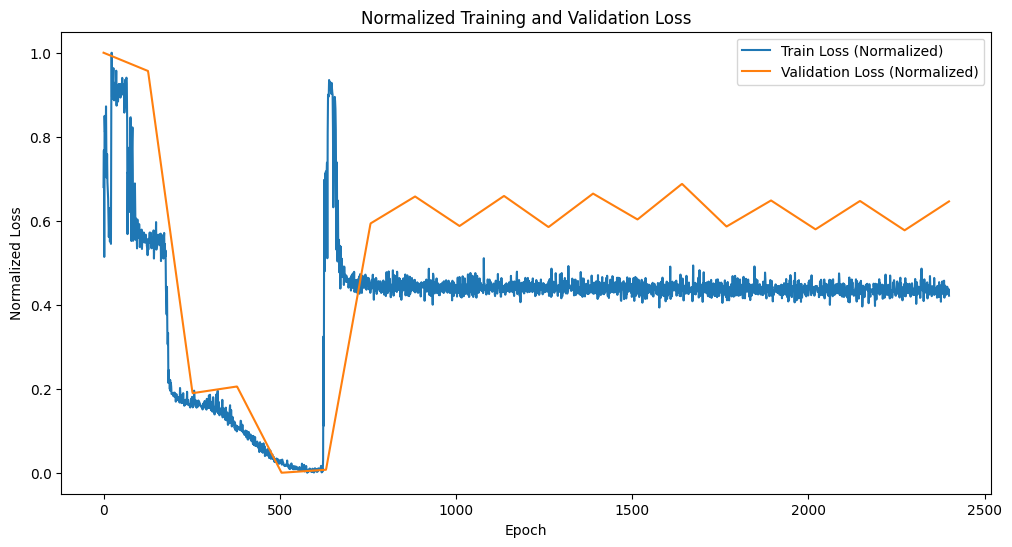

In [14]:
train_losses = np.array(train_losses_bkp[0:])
val_losses = np.array(val_losses_bkp[0:])
x_val = np.linspace(0, len(train_losses) - 1, len(val_losses))
x_train = np.arange(len(train_losses))
val_losses_interpolated = np.interp(x_train, x_val, val_losses)

# Step 2: Normalization of both losses
scaler = MinMaxScaler()


# combined_losses = np.concatenate((loss_train, loss_val_interpolated)).reshape(-1, 1)
# scaler.fit(combined_losses)

# Reshape for sklearn which expects 2D array
train_losses_normalized = scaler.fit_transform(train_losses.reshape(-1, 1)).flatten()
val_losses_normalized = scaler.fit_transform(val_losses_interpolated.reshape(-1, 1)).flatten()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(train_losses_normalized, label='Train Loss (Normalized)')
plt.plot(val_losses_normalized, label='Validation Loss (Normalized)')
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.title('Normalized Training and Validation Loss')
# plt.ylim(0, 0.05)
plt.legend()
plt.show()

In [15]:
# _, _, test_loader = get_dataset_and_dataloaders(train_bs=128, test_bs=1, num_samples=4000, rb_path='../../data/replay_buffer_rope.pkl')

In [16]:
import plotly.io as pio
pio.renderers.default = 'notebook'
import plotly.graph_objects as go


model.eval()
loss = []
statesss = []
actionsss = []
actions_gt = []
possss = []

grand_data = np.zeros((100, 128, 10, 2))
with torch.no_grad():
    with tqdm.tqdm(actor_test_loader, desc=f"Validation", leave=False, mininterval=1) as v:
        for i, (s1, a, s2, p, r, d, N) in enumerate(v):
            N = int(torch.max(N))
            
            actions = a[:1, :N].to(hp_dict['dev_rl'])
            bs = actions.shape[0]
            ones_column = -0.02*torch.rand(bs, N, 1, device=hp_dict['dev_rl']) + 0.01
            actions_3d = torch.cat([actions, ones_column], dim=2)
            actions_gt.append(actions)

            # Conditioning Variables
            states = s1[:1, :N].to(hp_dict['dev_rl'])
            statesss.append(states)
            next_states = s2[:, :N].to(hp_dict['dev_rl'])
            # print(actions, states)
            pos = p[:1, :N].to(hp_dict['dev_rl'])
            possss.append(pos)
    
            output_actions = model.get_actions(states, pos, deterministic=True)[:,:N,:2]
            
            actionsss.append(output_actions)
            loss.append((actions[:1, :N].cpu().detach().numpy() - output_actions.cpu().detach().numpy()).mean()**2)
            
            if i>60:
                break


0.00023024873710331297

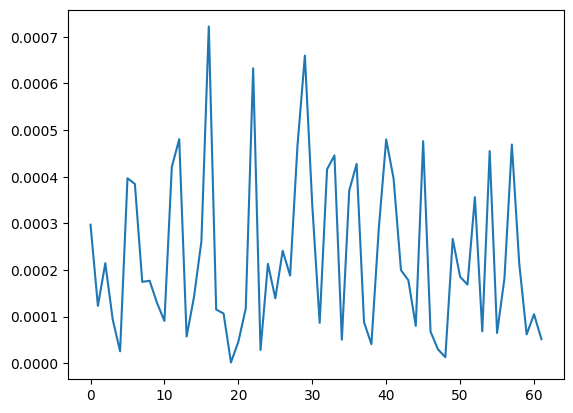

In [17]:
plt.plot(loss)
np.mean(loss)
# 3.2210364e-06

In [18]:
# plt.plot(loss)
# np.mean(loss)
# 3.7359464e-06

6


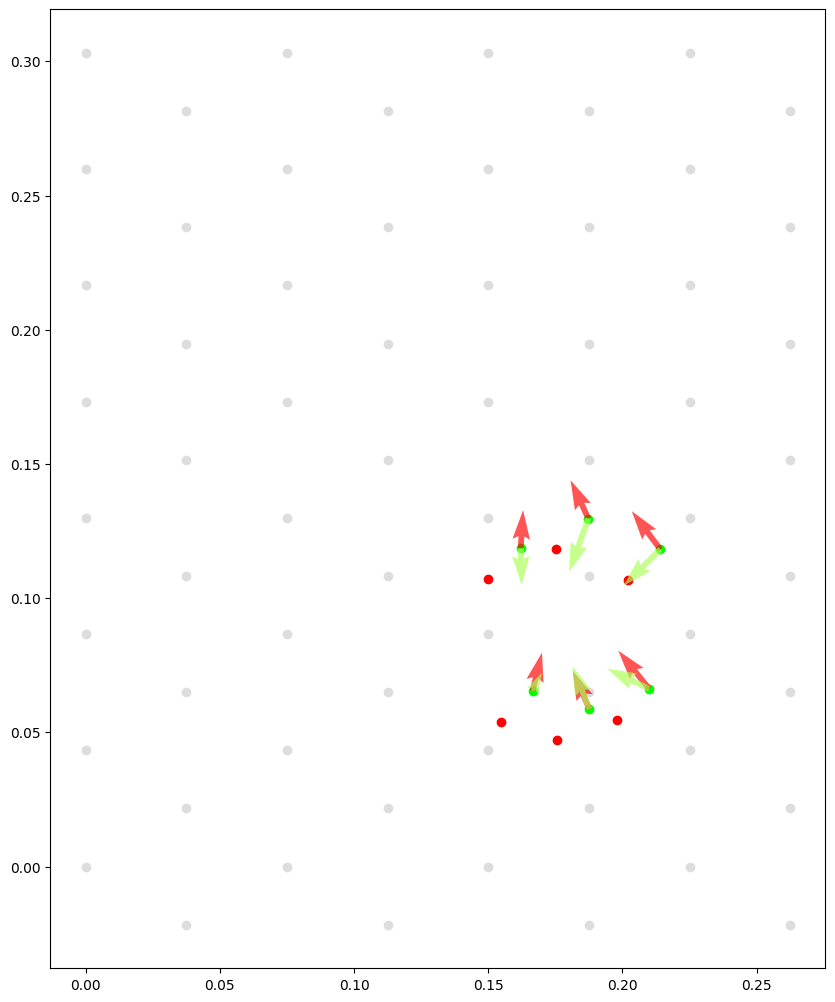

8


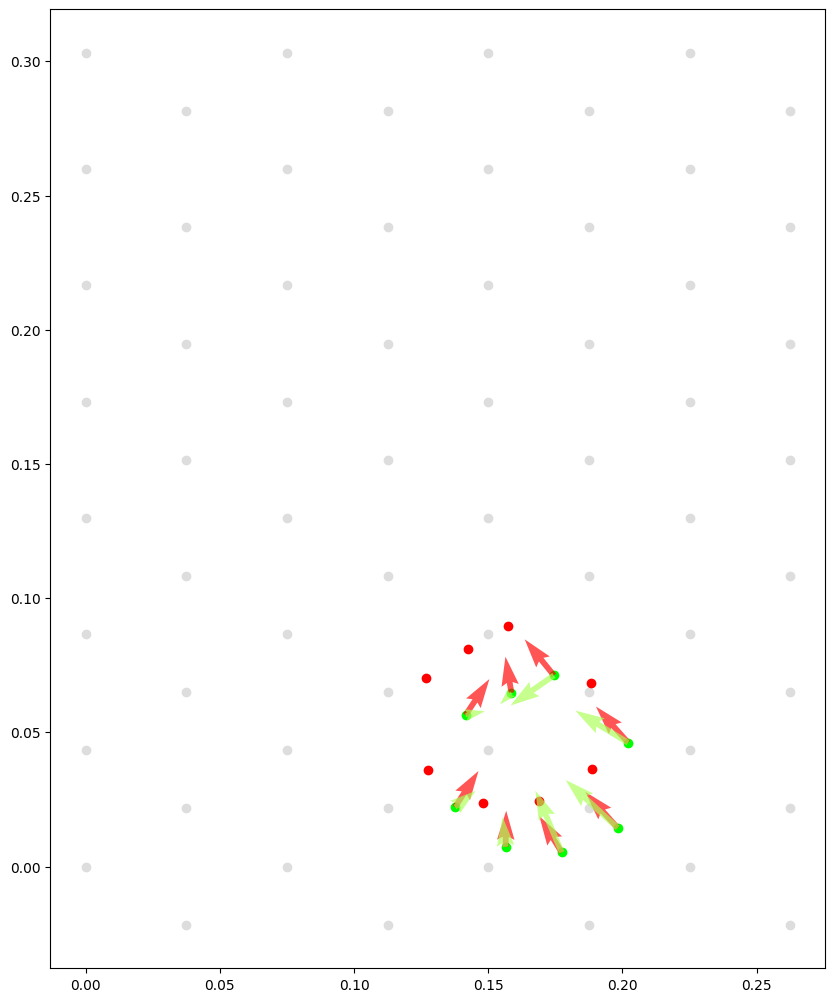

7


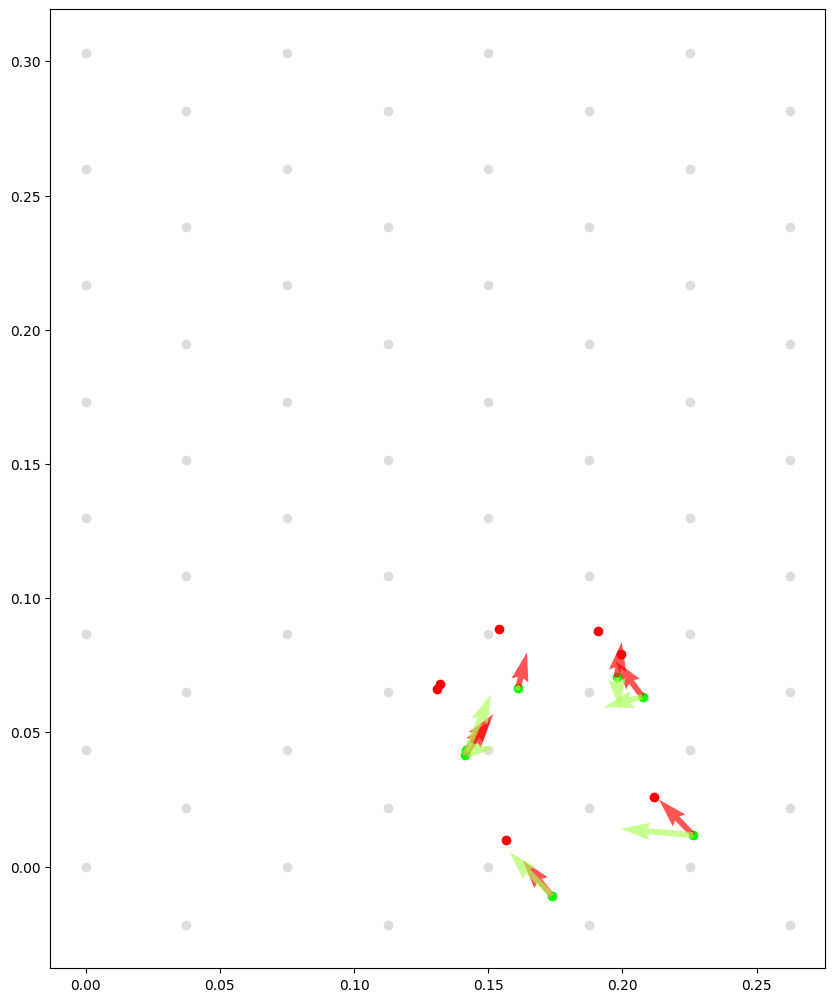

7


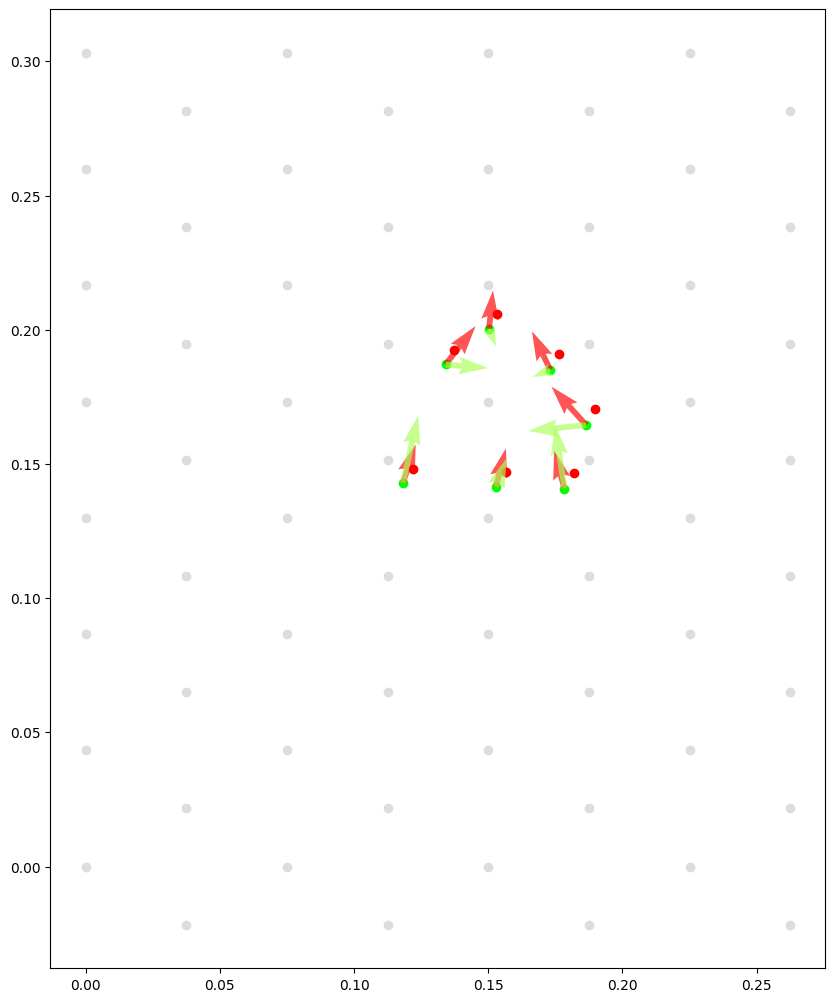

6


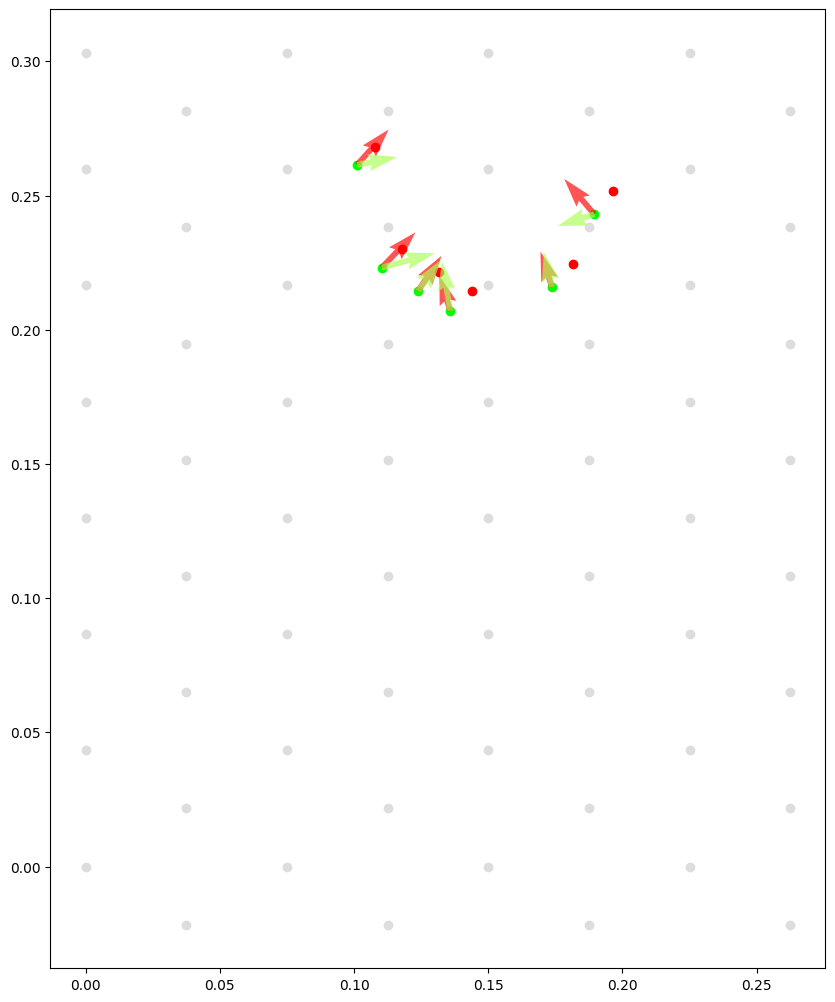

8


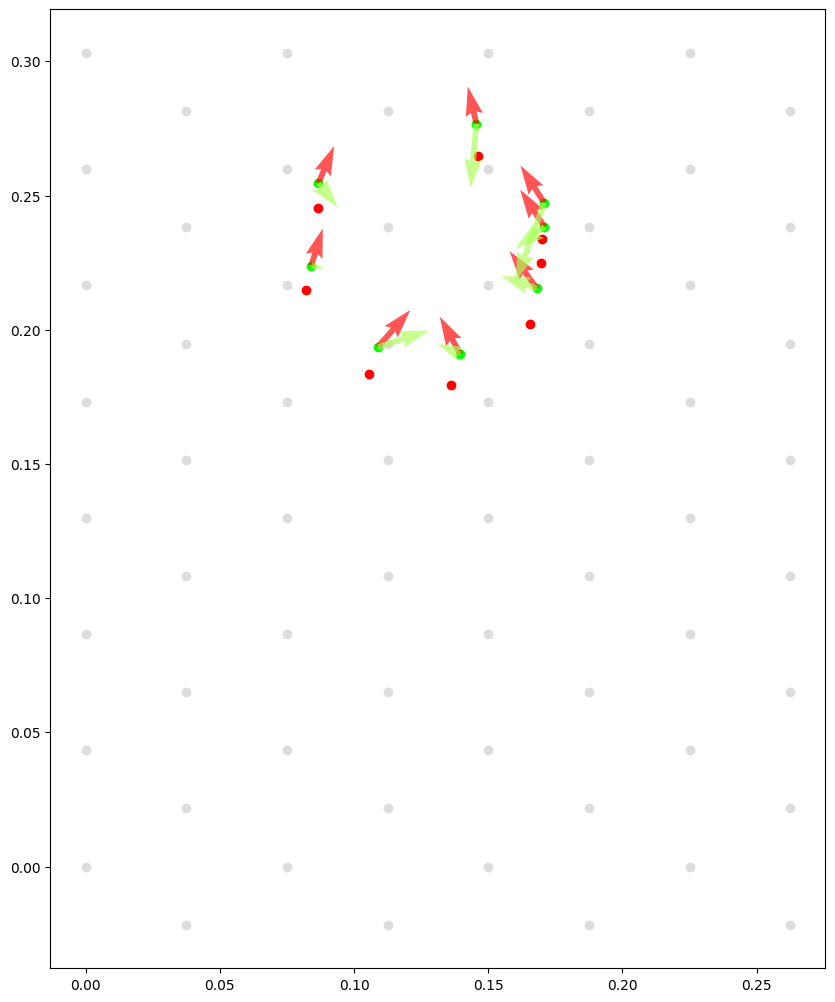

9


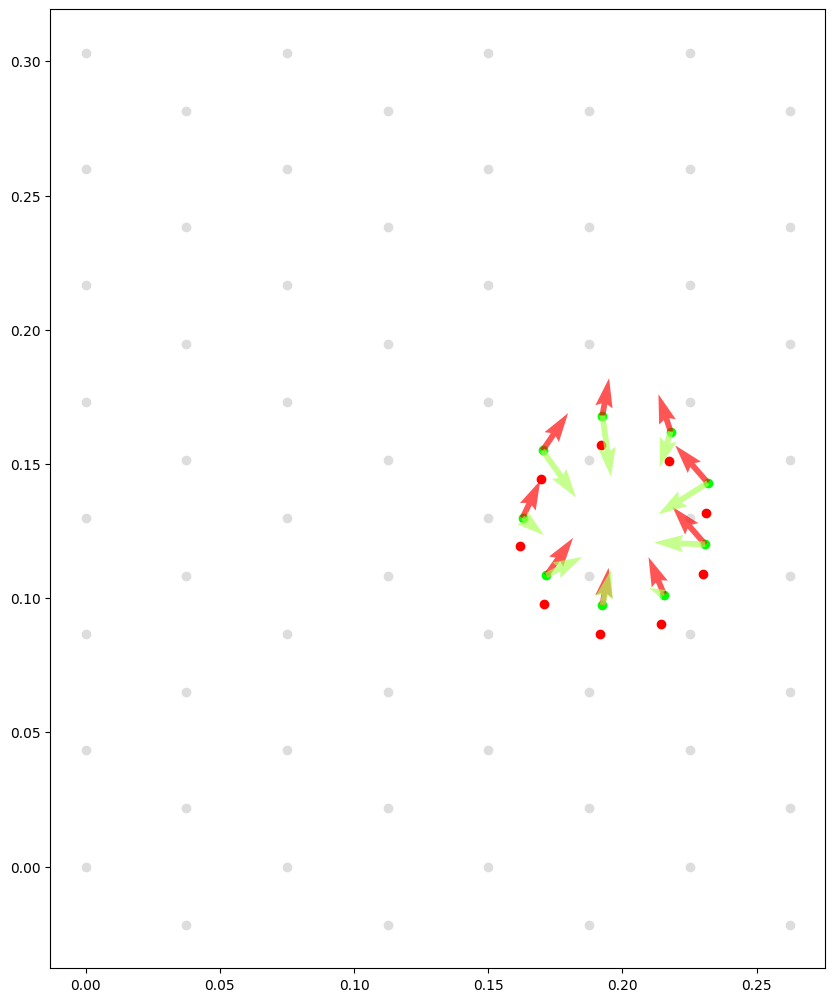

7


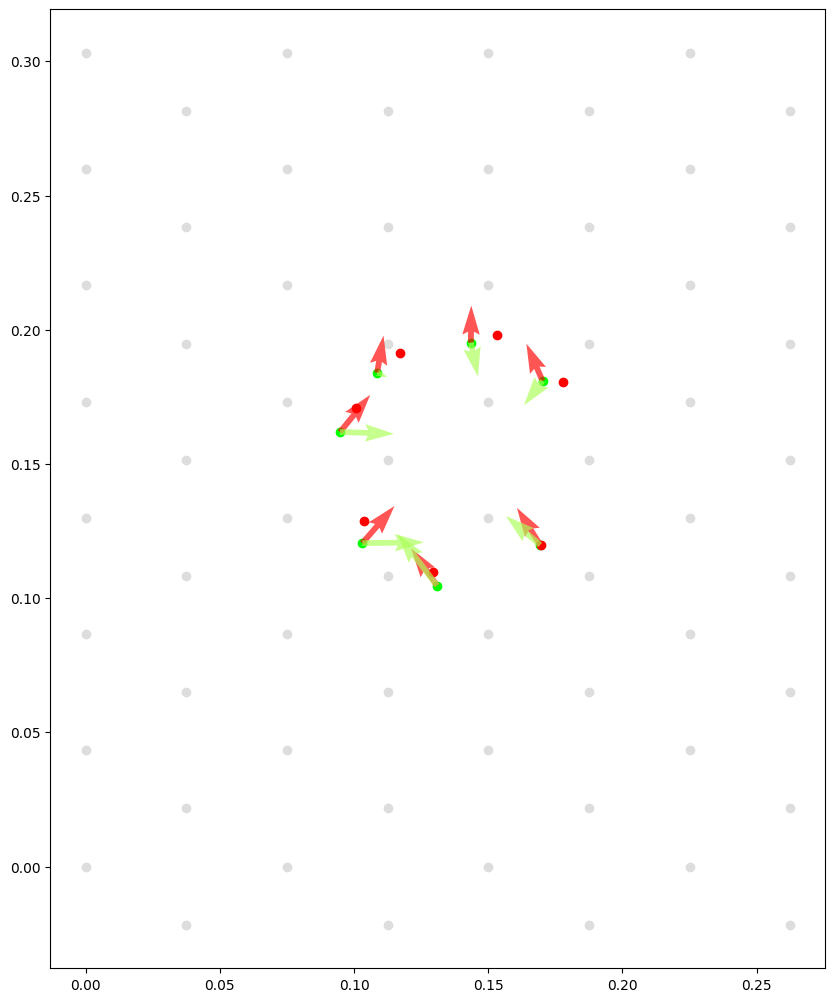

6


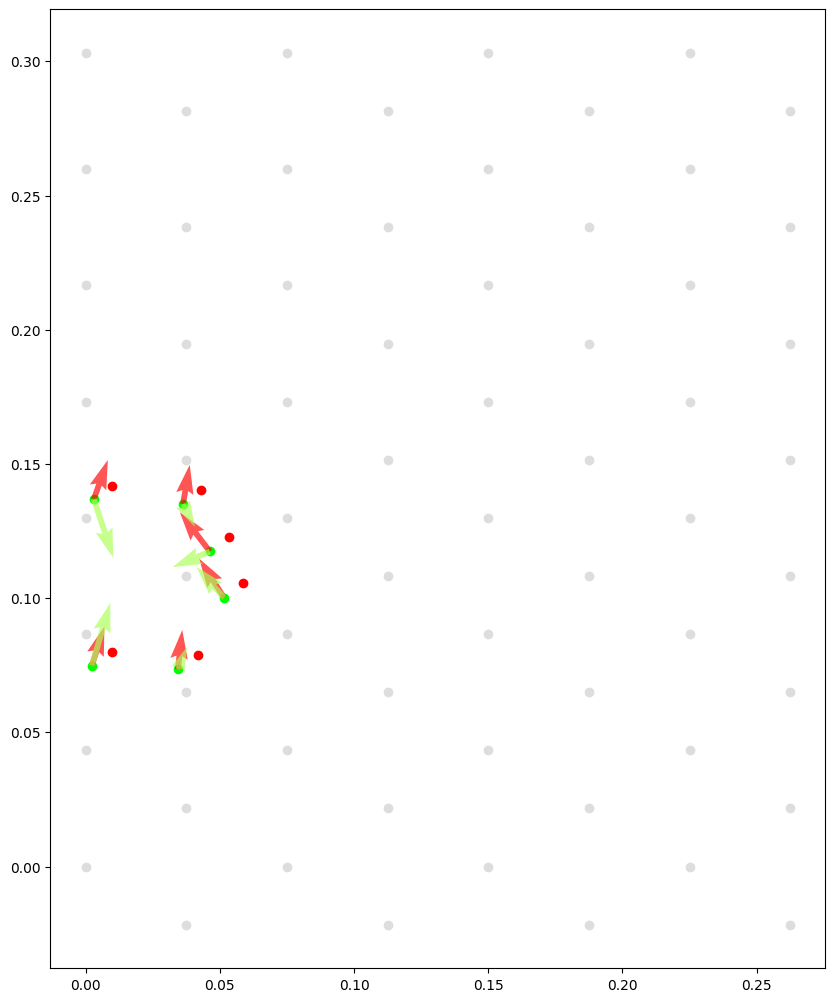

6


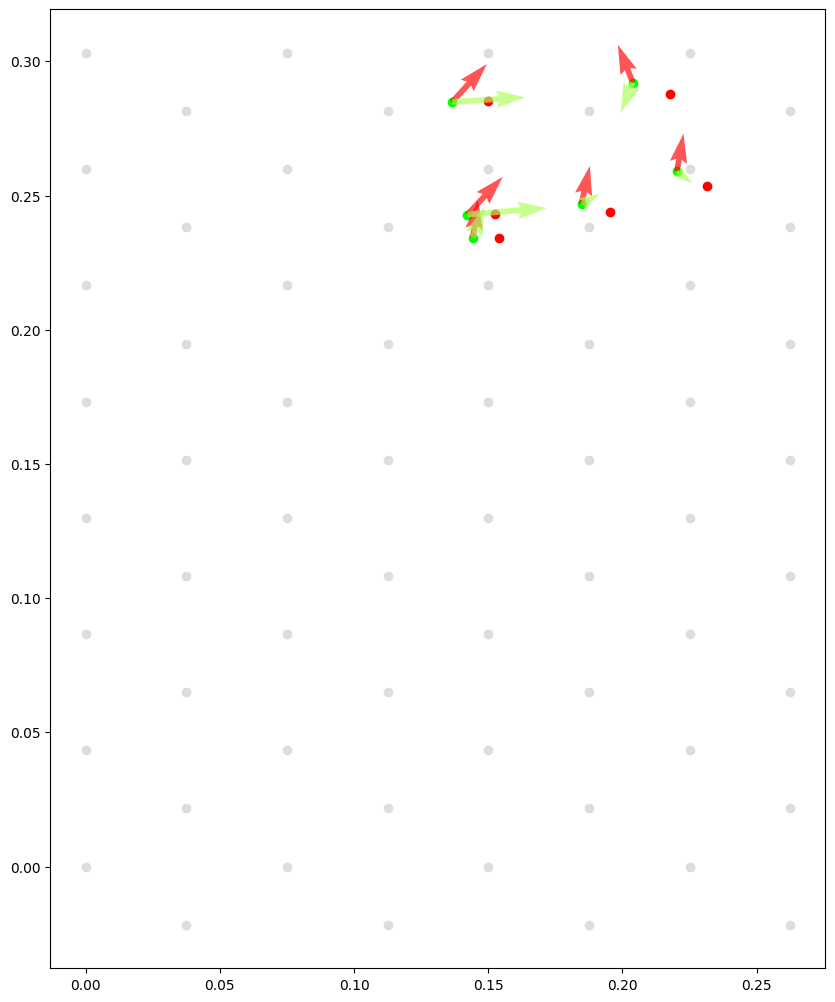

8


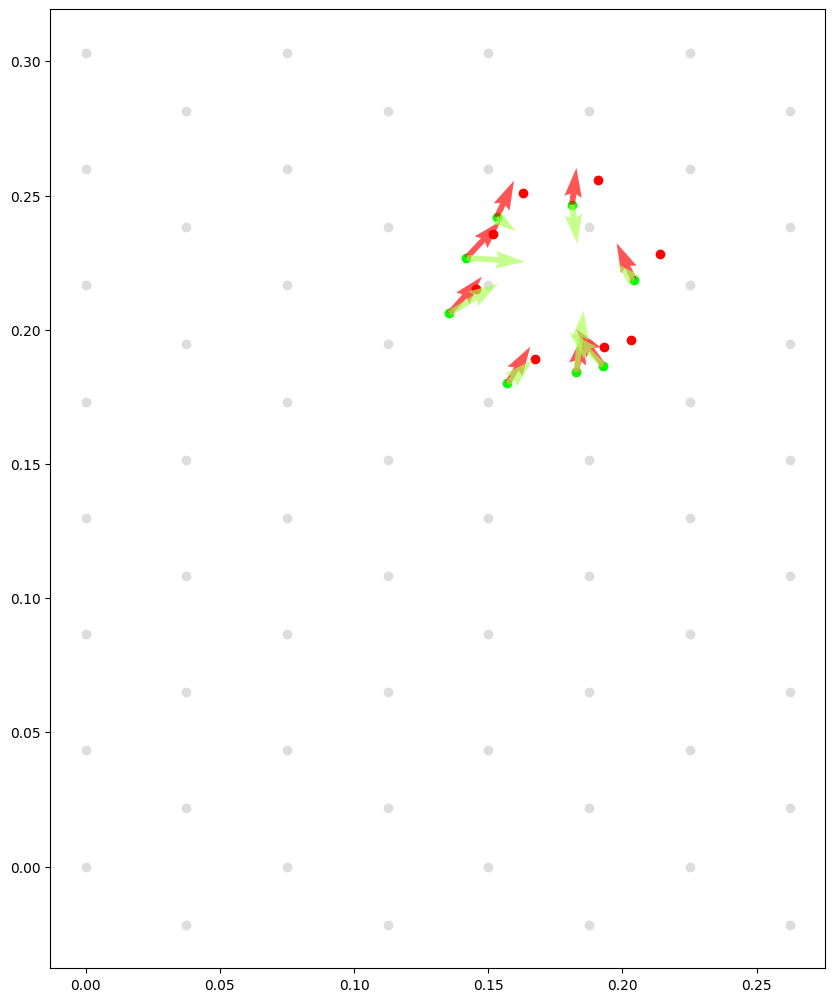

5


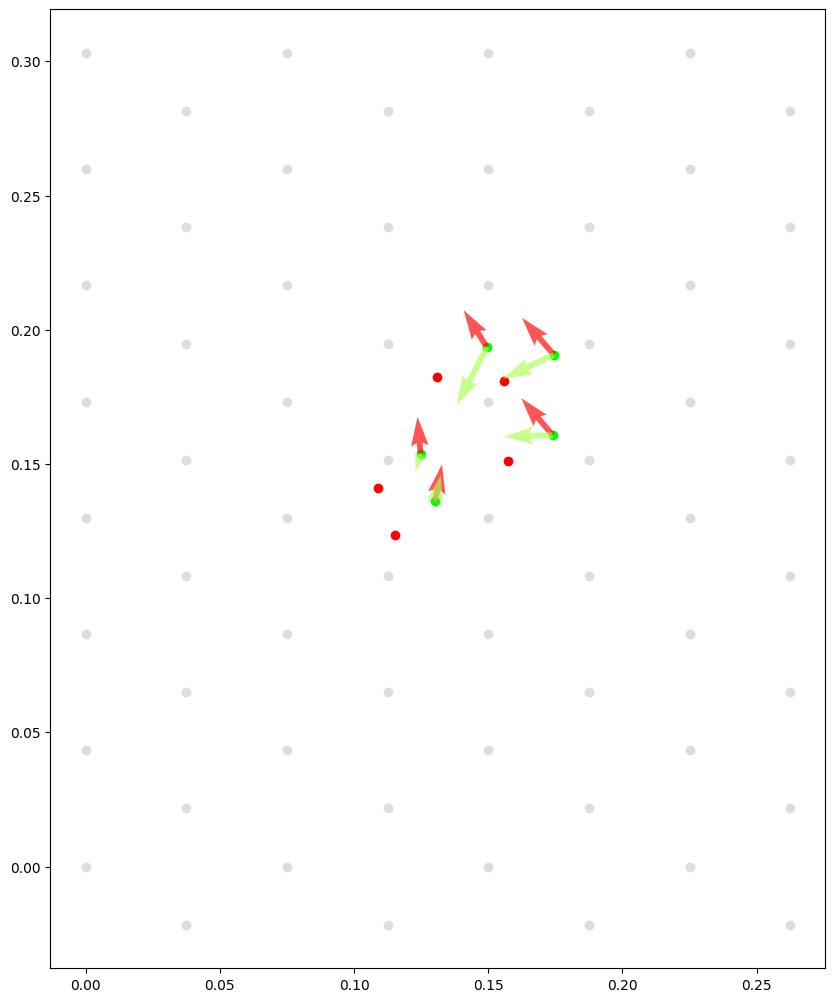

9


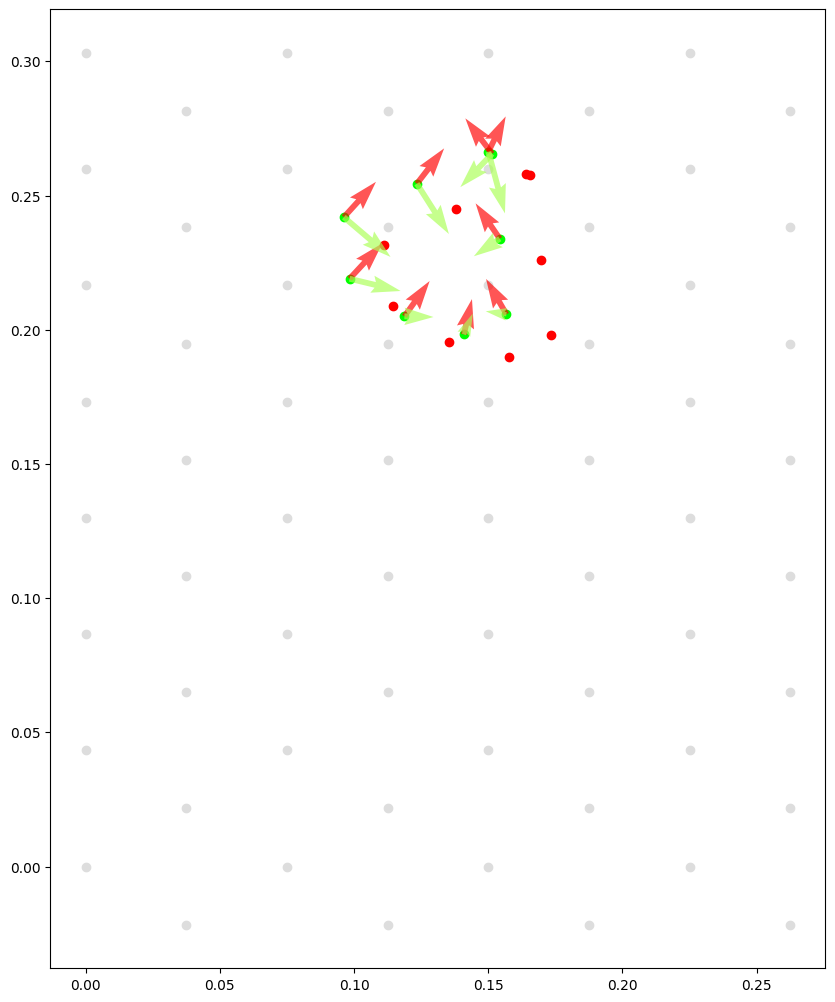

9


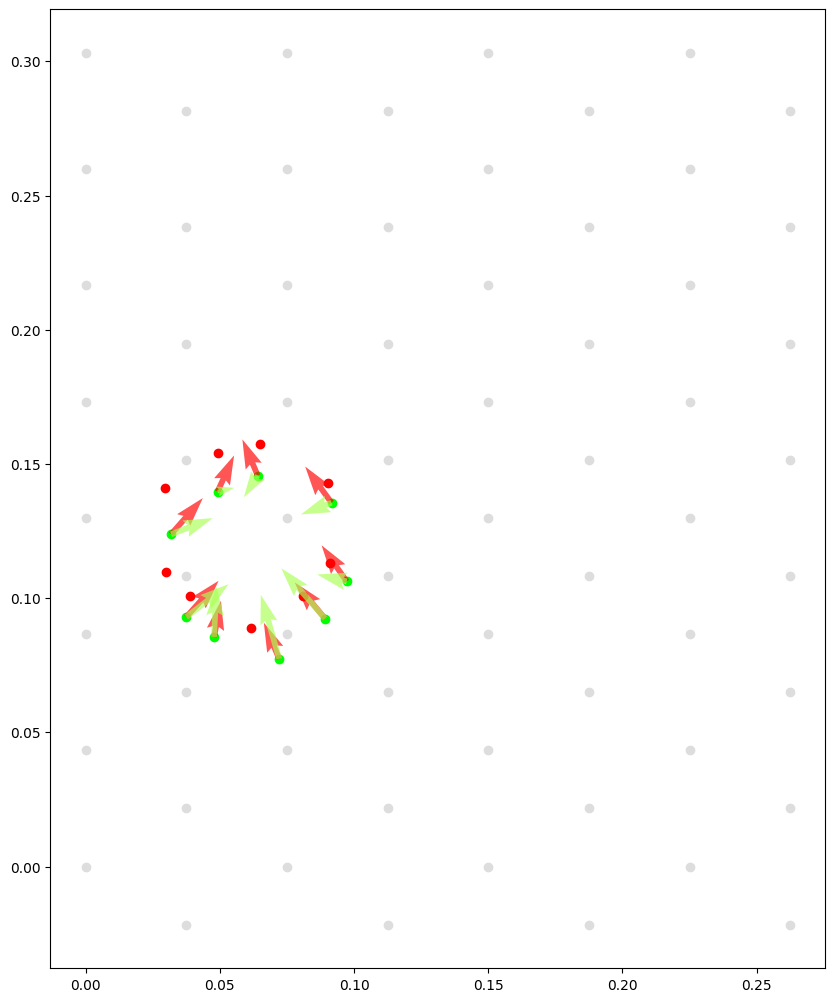

7


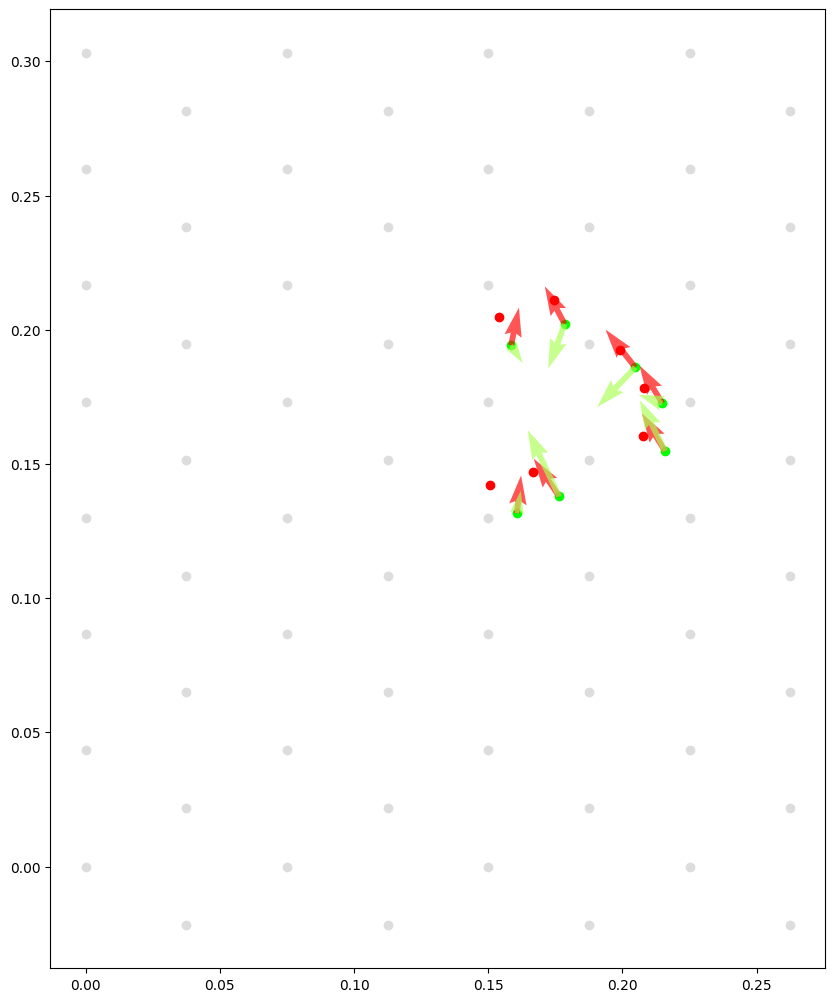

10


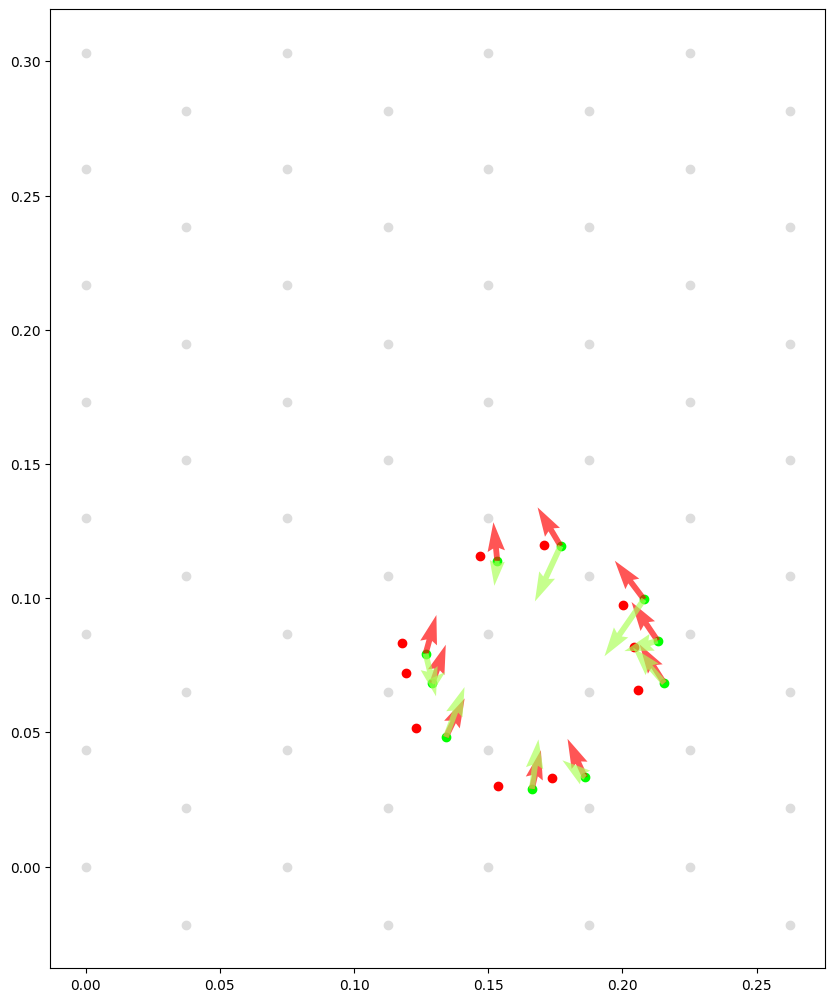

8


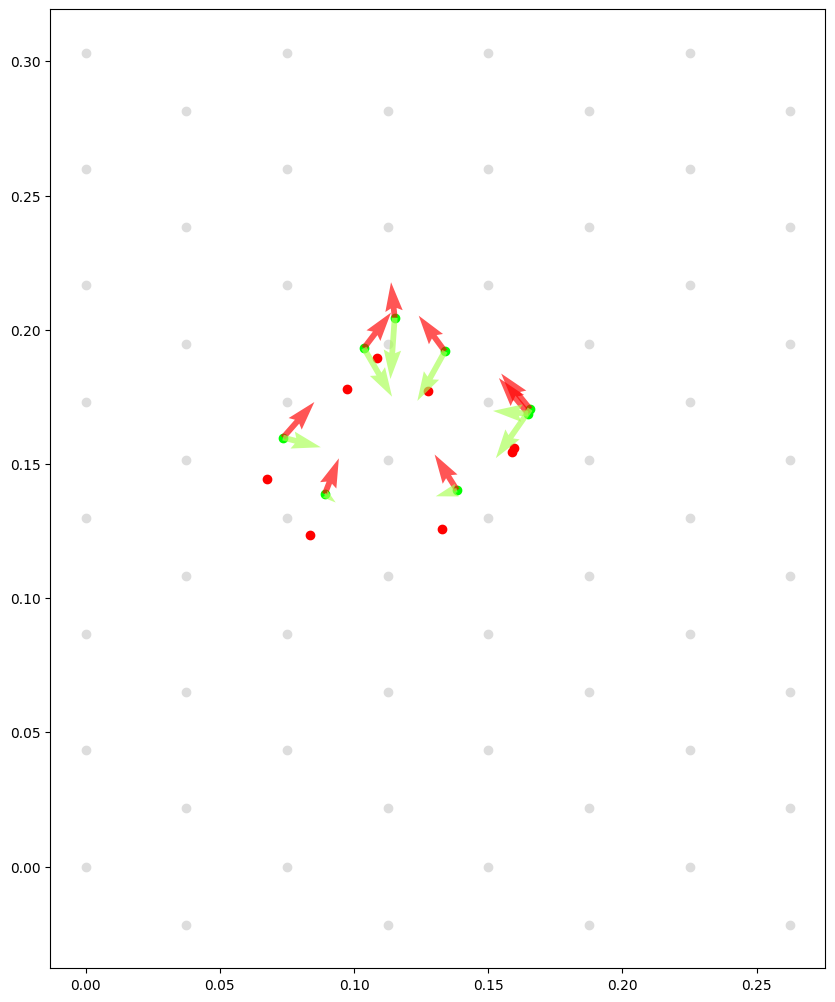

6


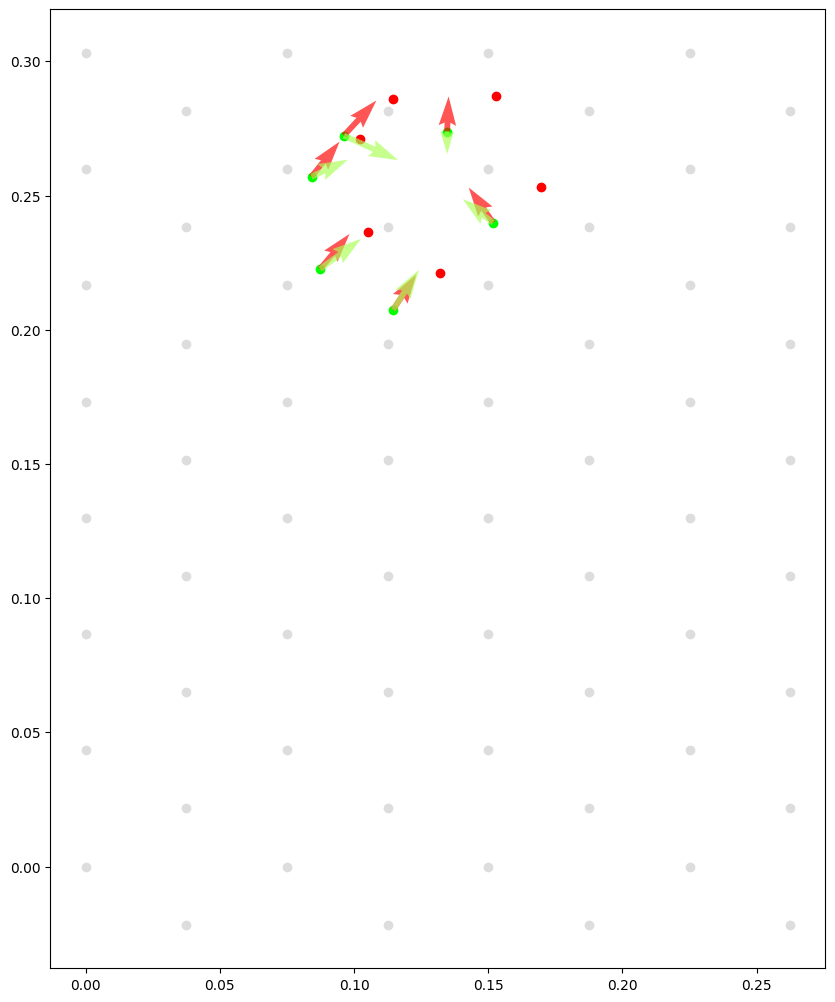

7


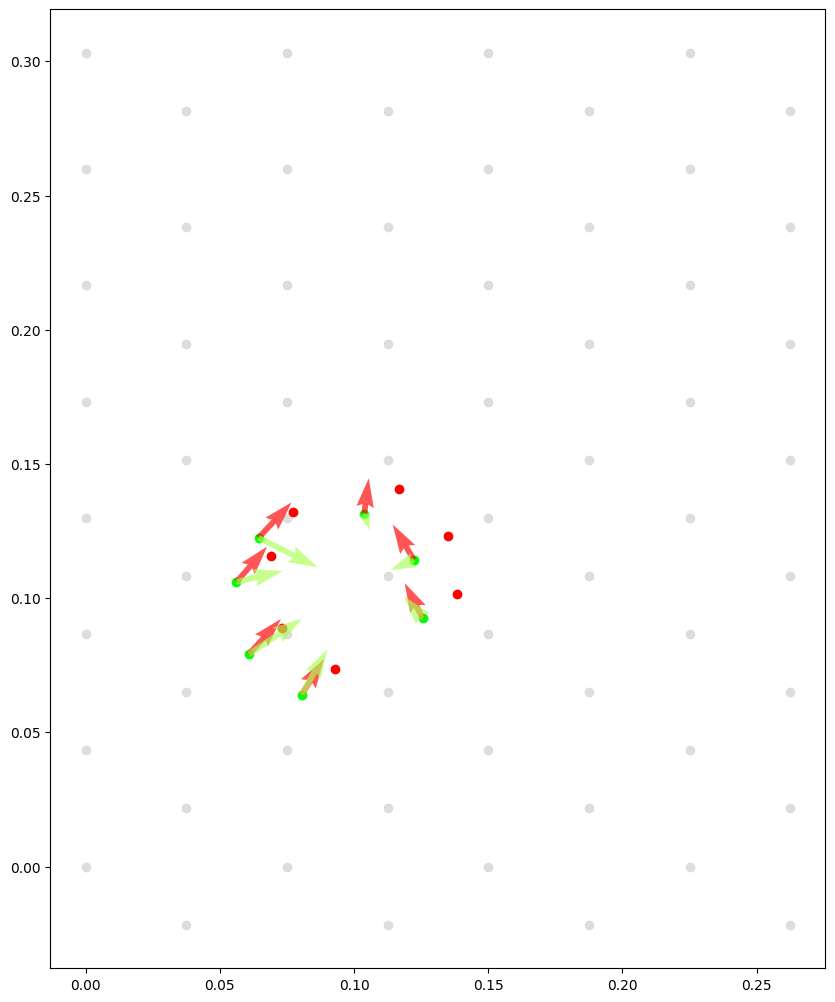

9


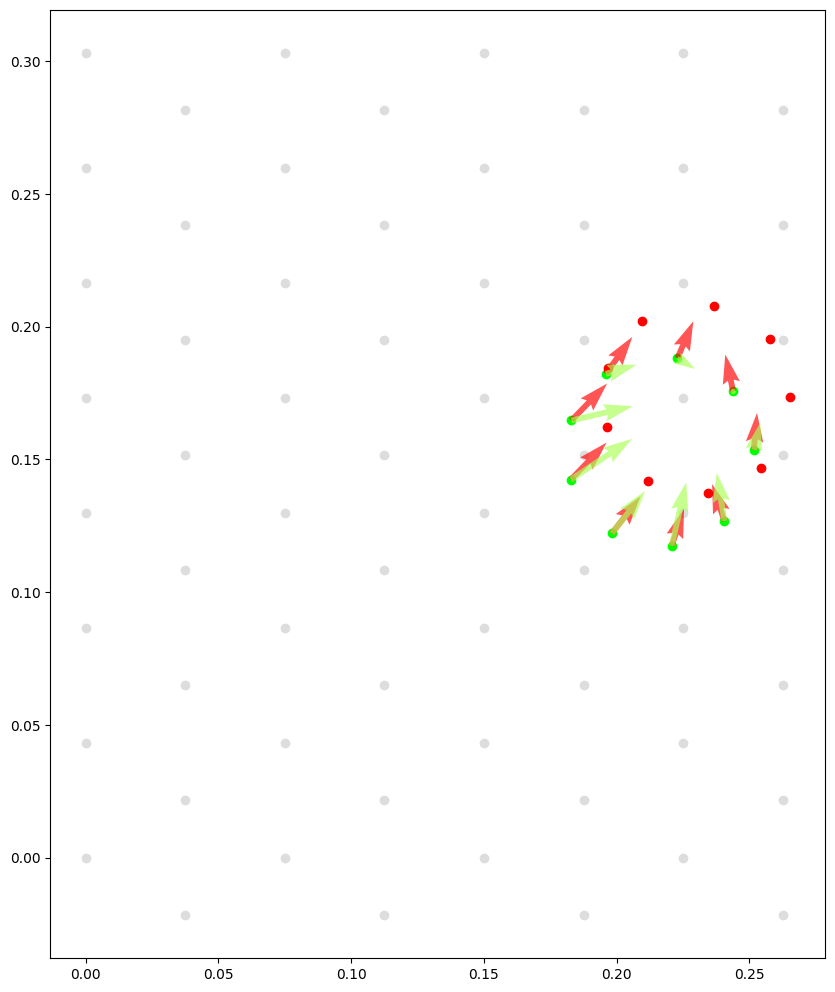

10


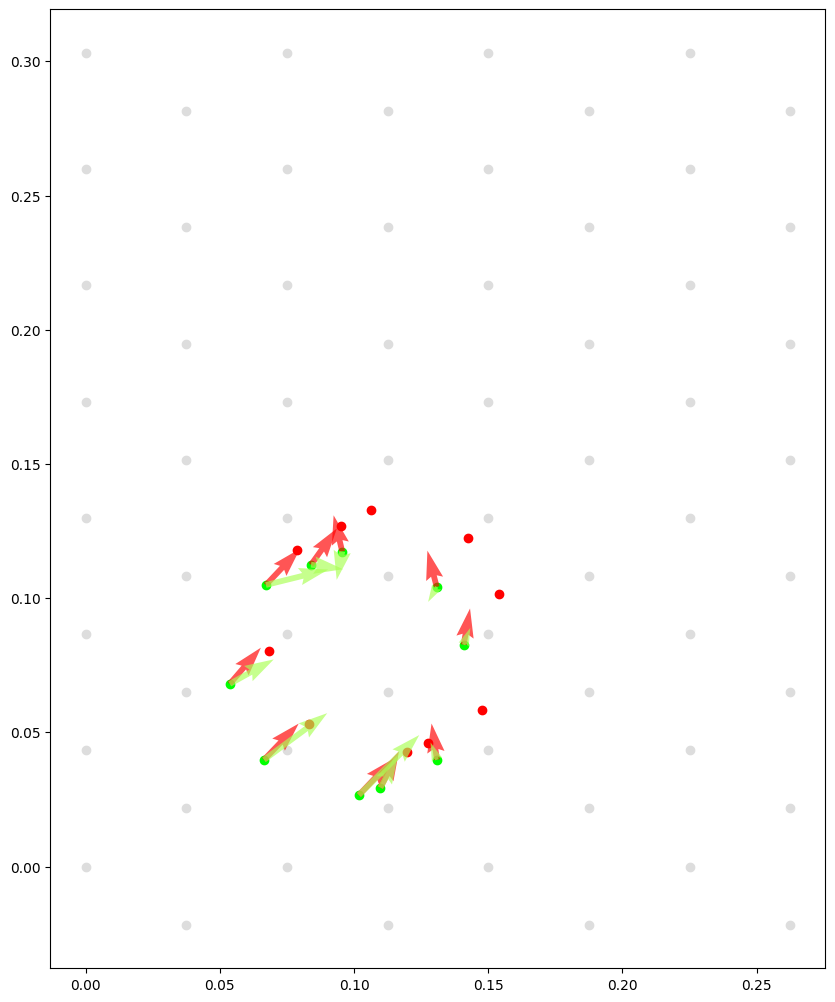

5


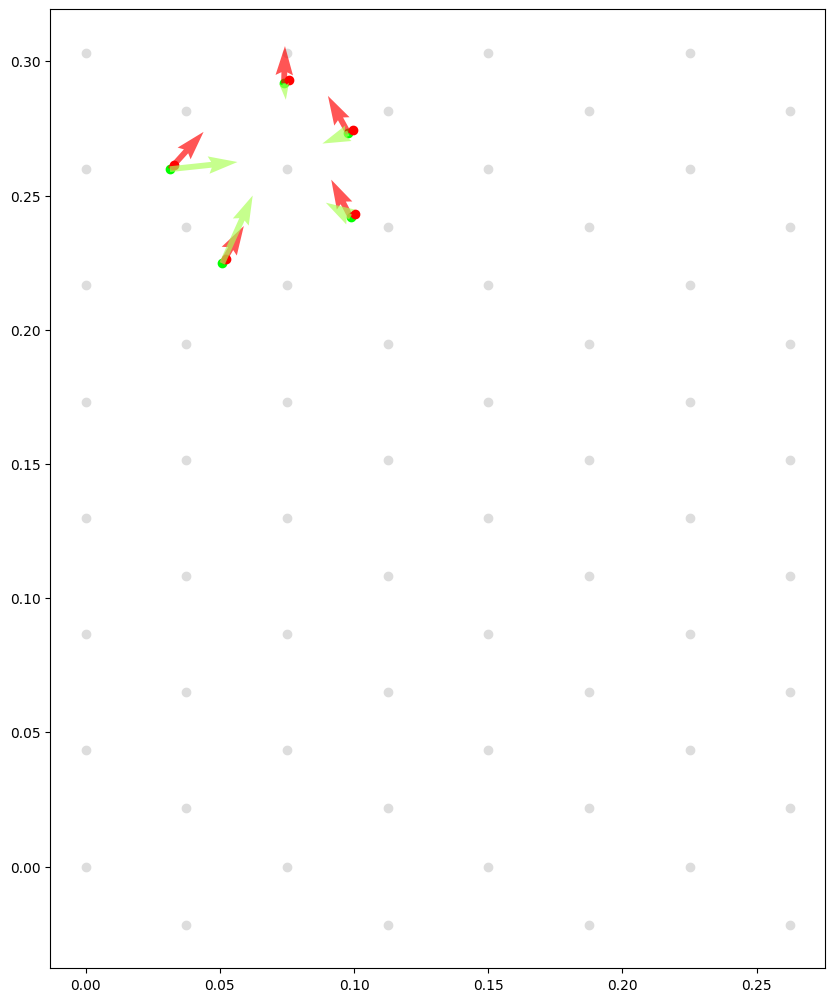

7


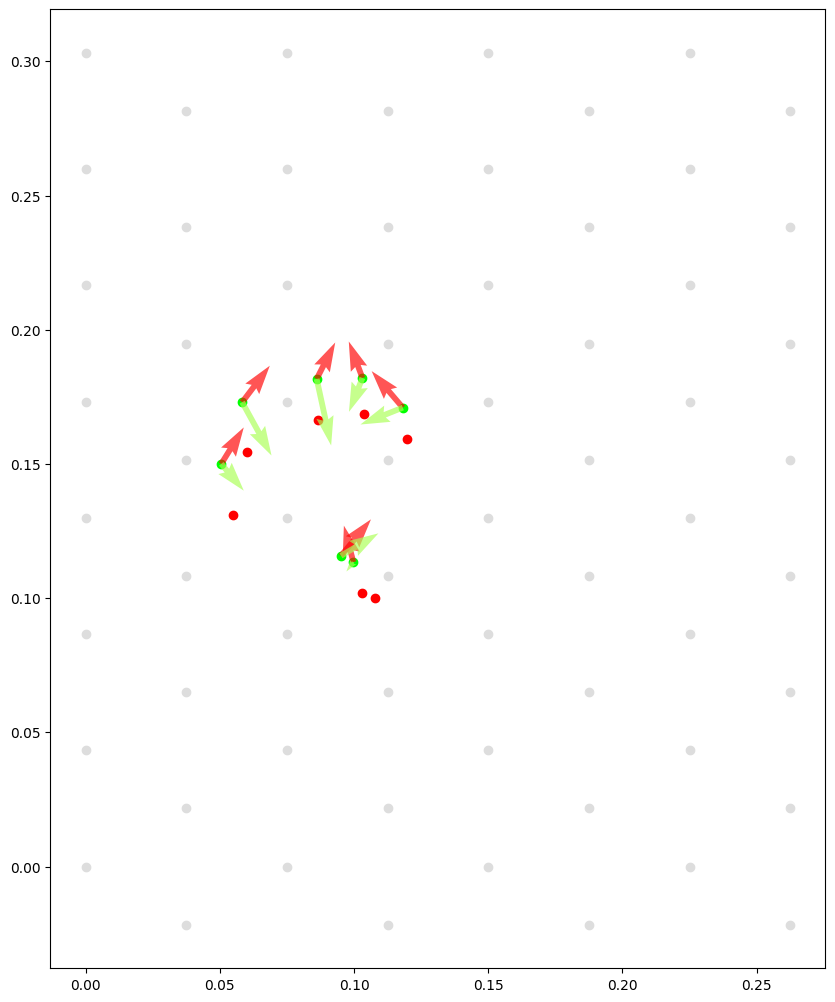

9


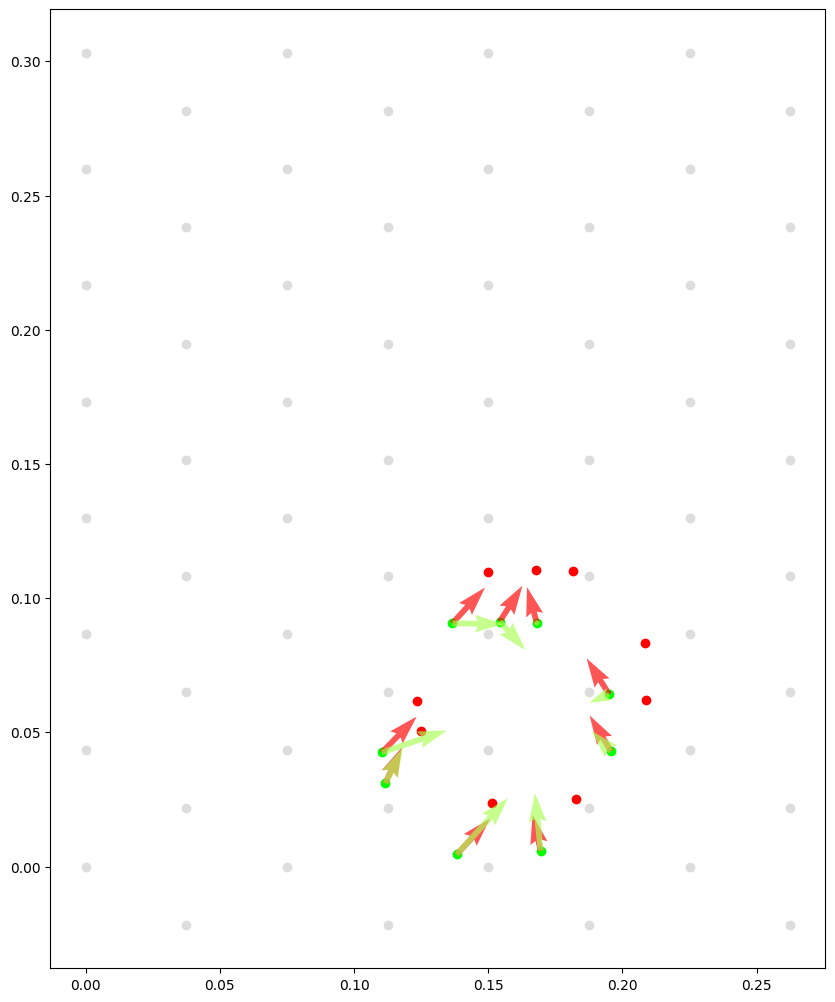

7


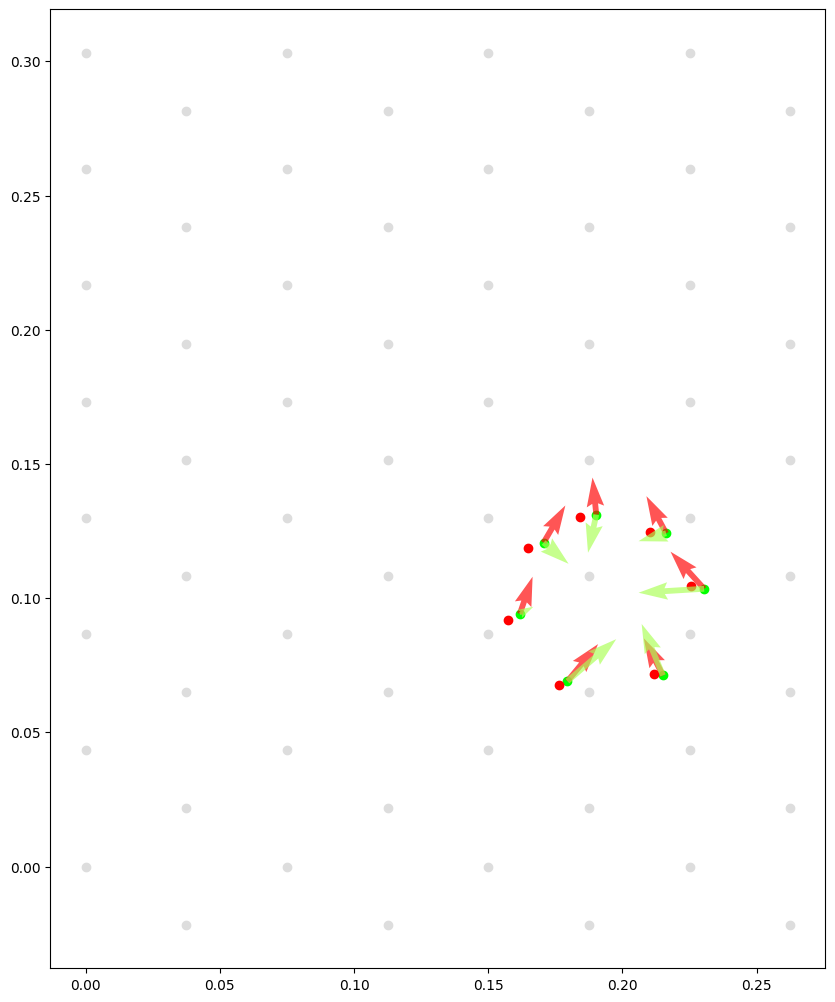

8


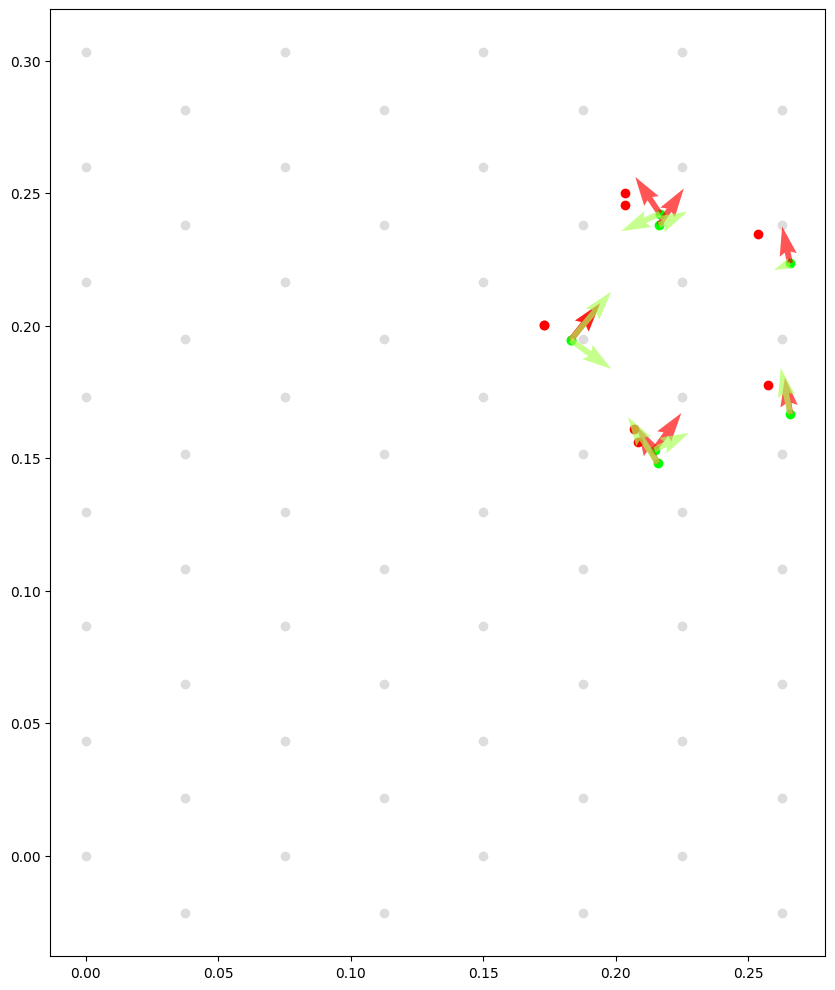

8


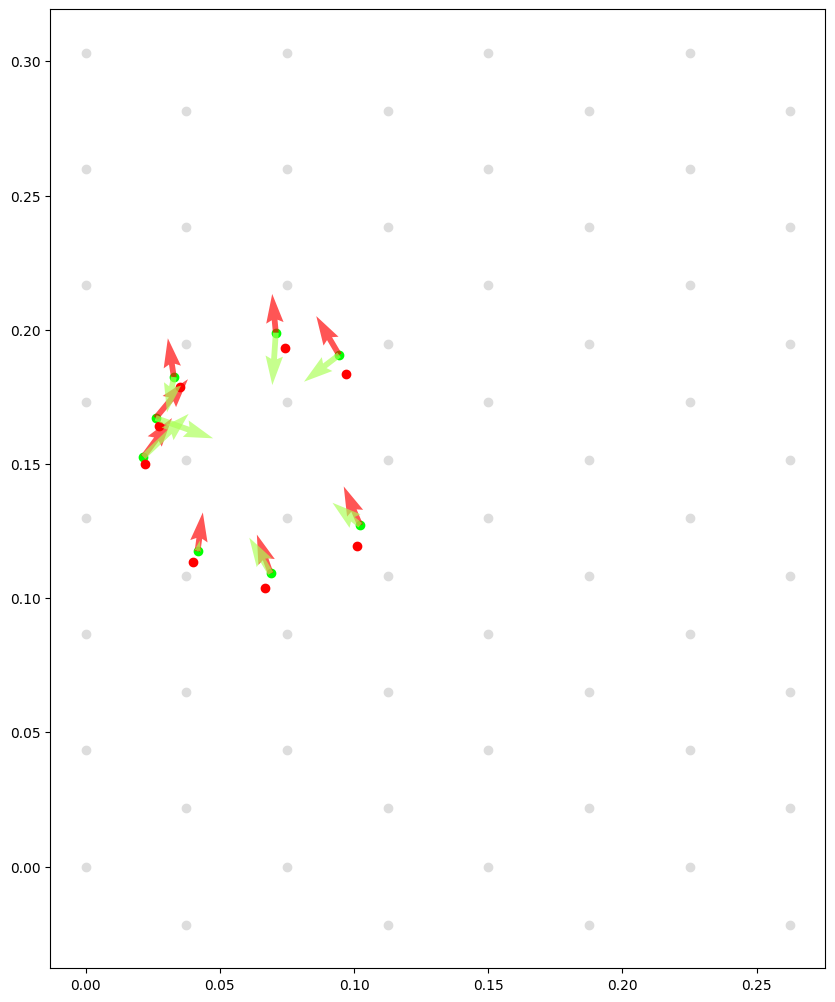

6


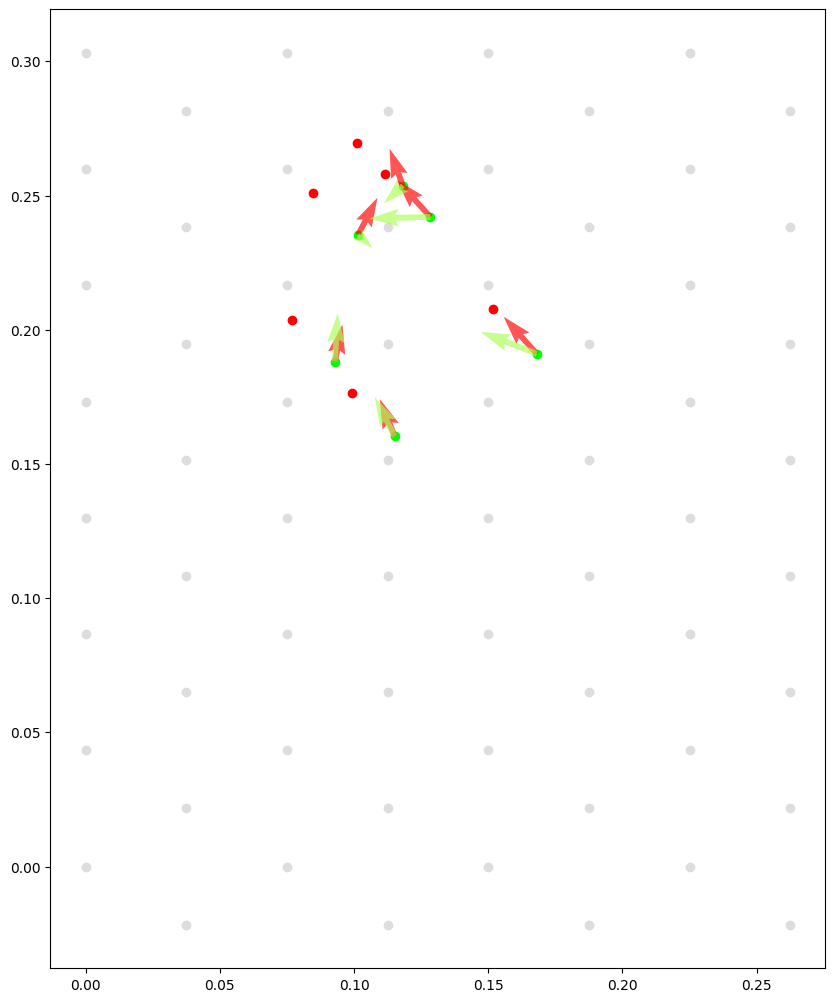

8


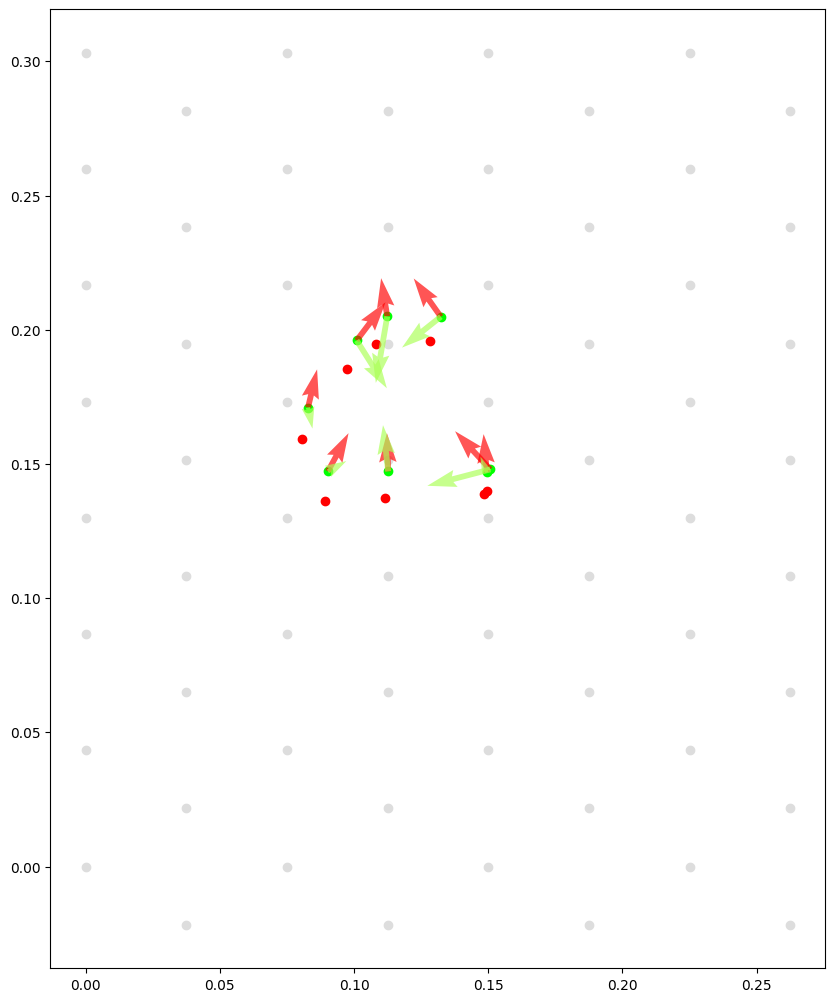

8


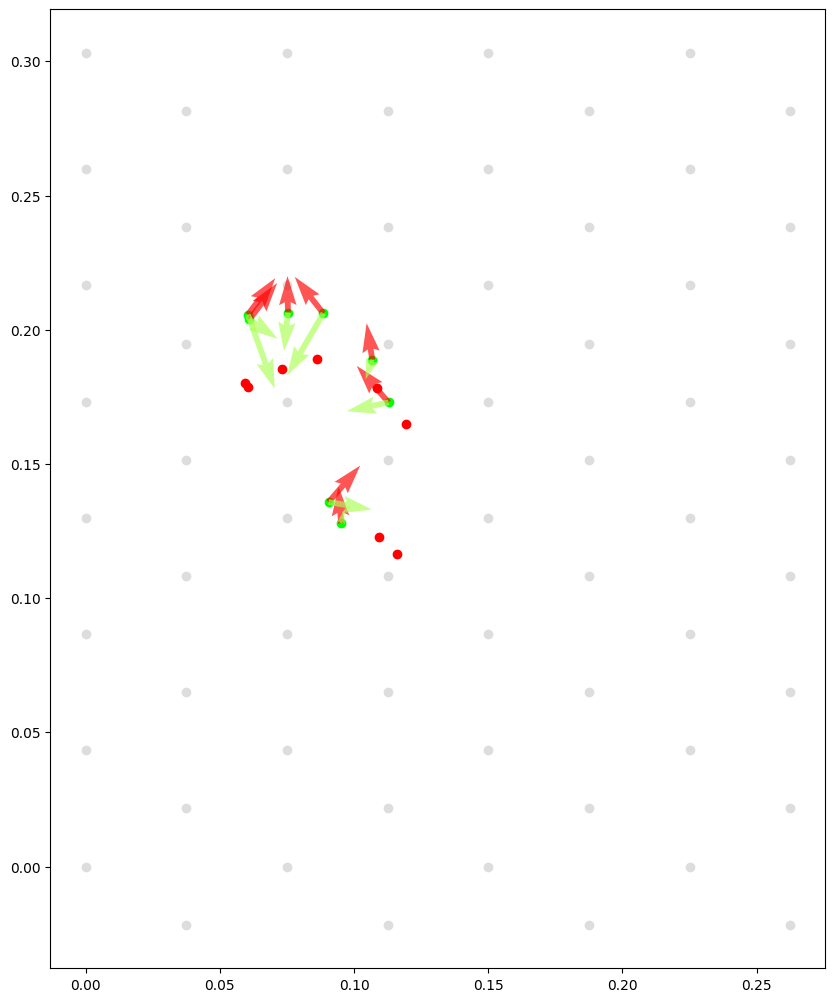

7


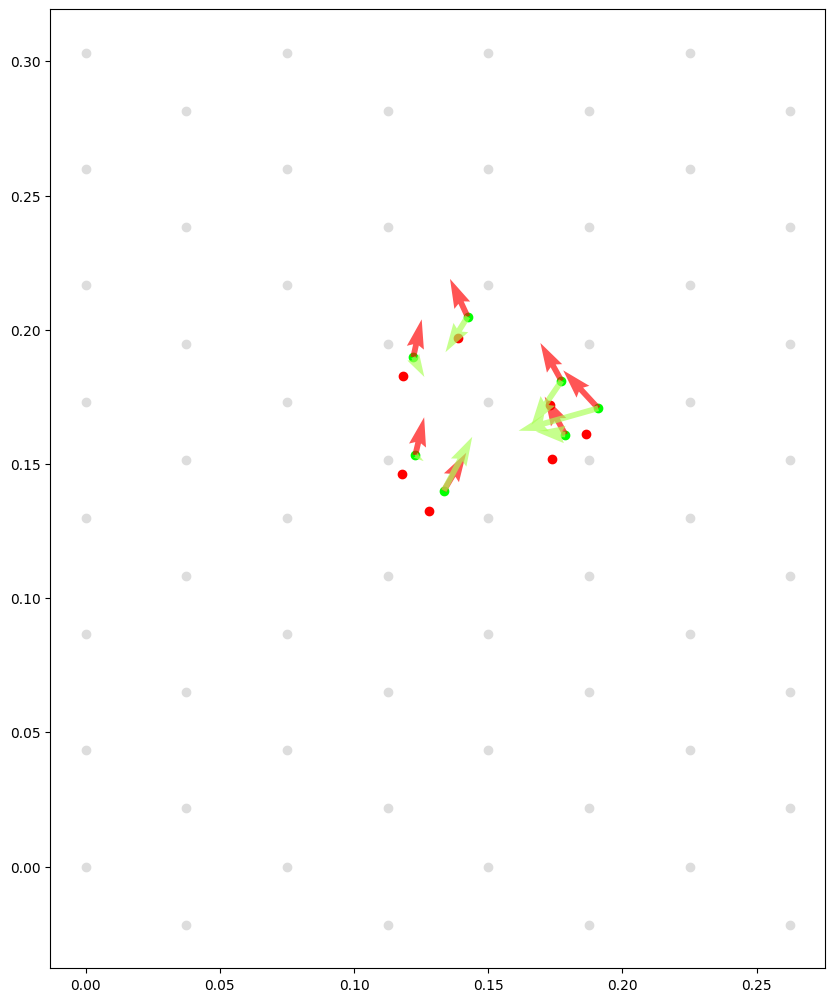

6


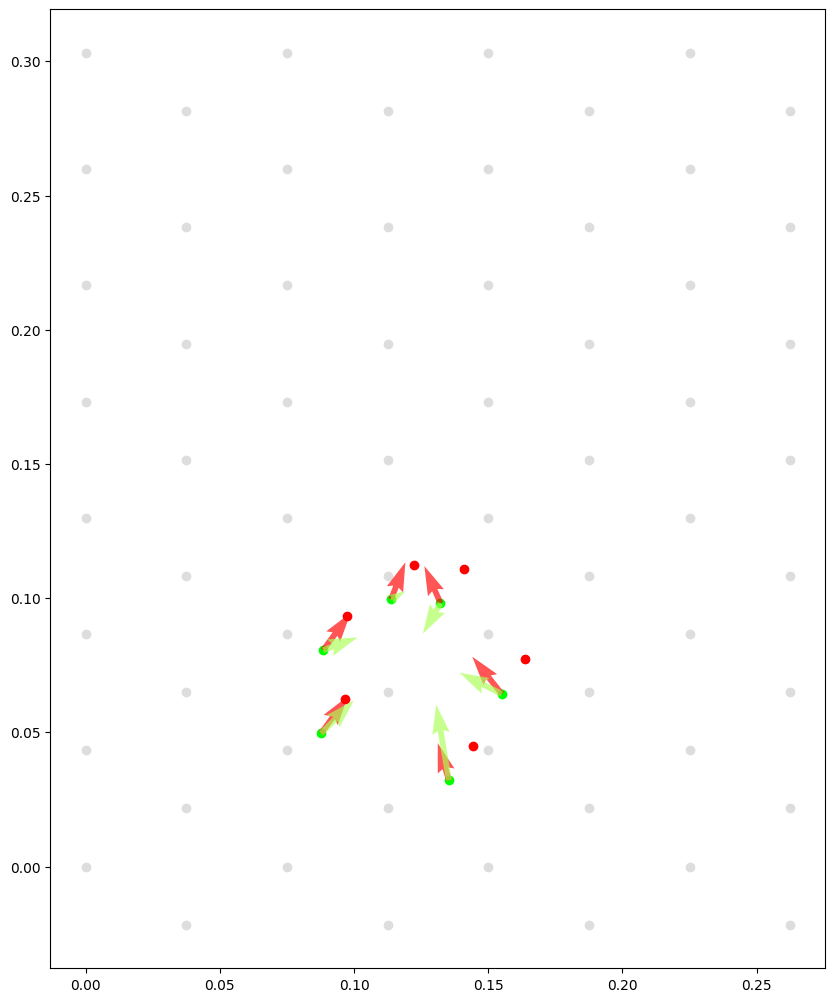

7


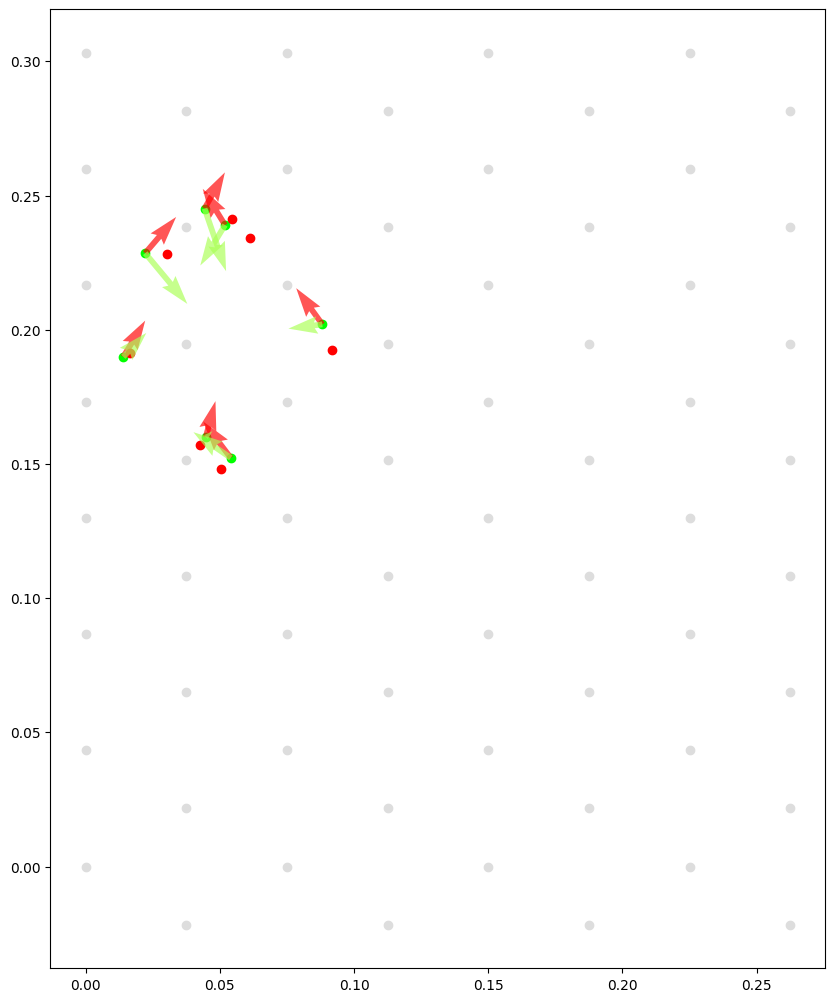

5


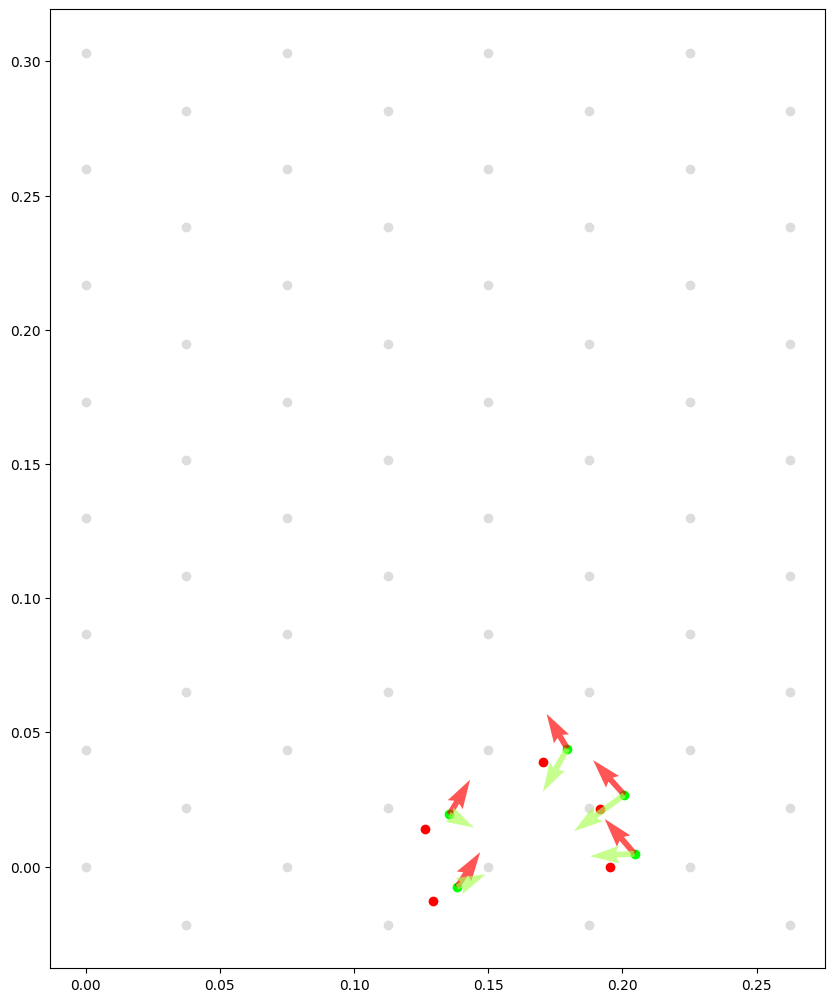

6


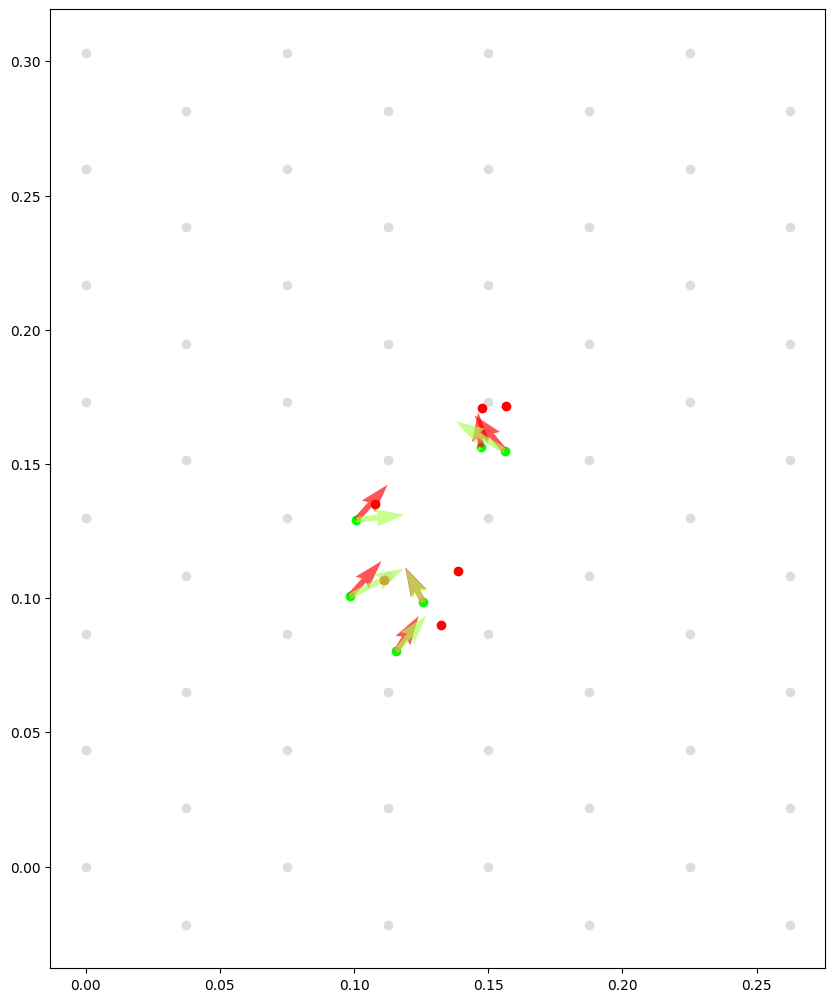

9


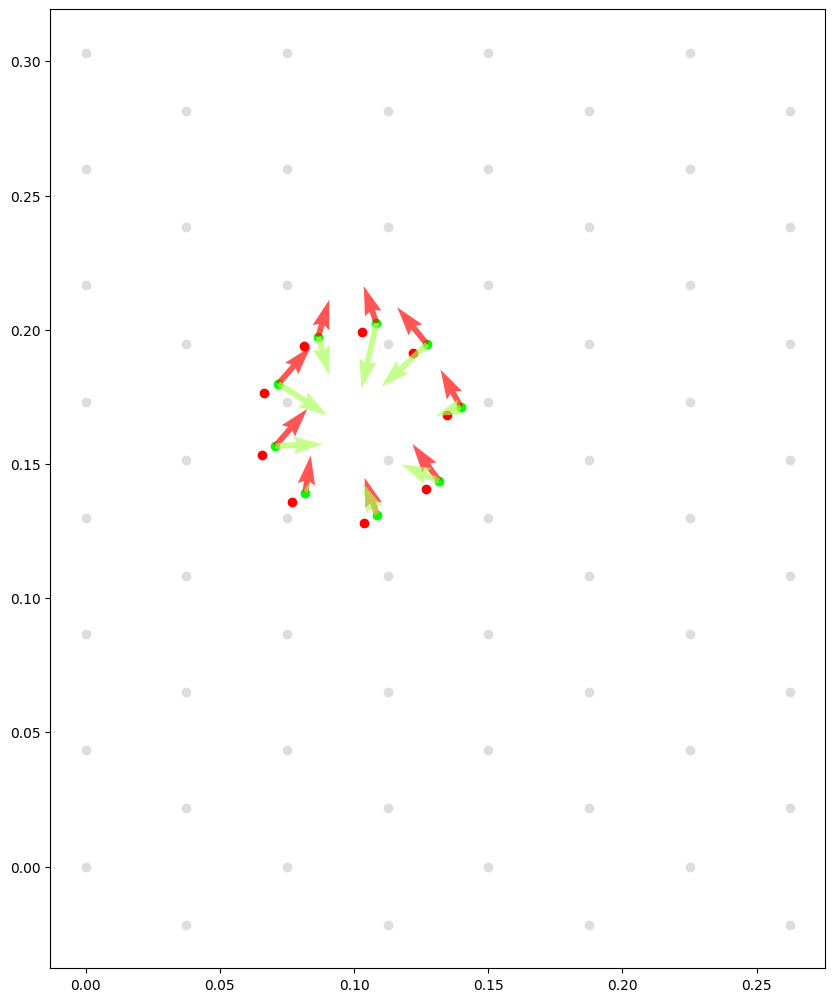

8


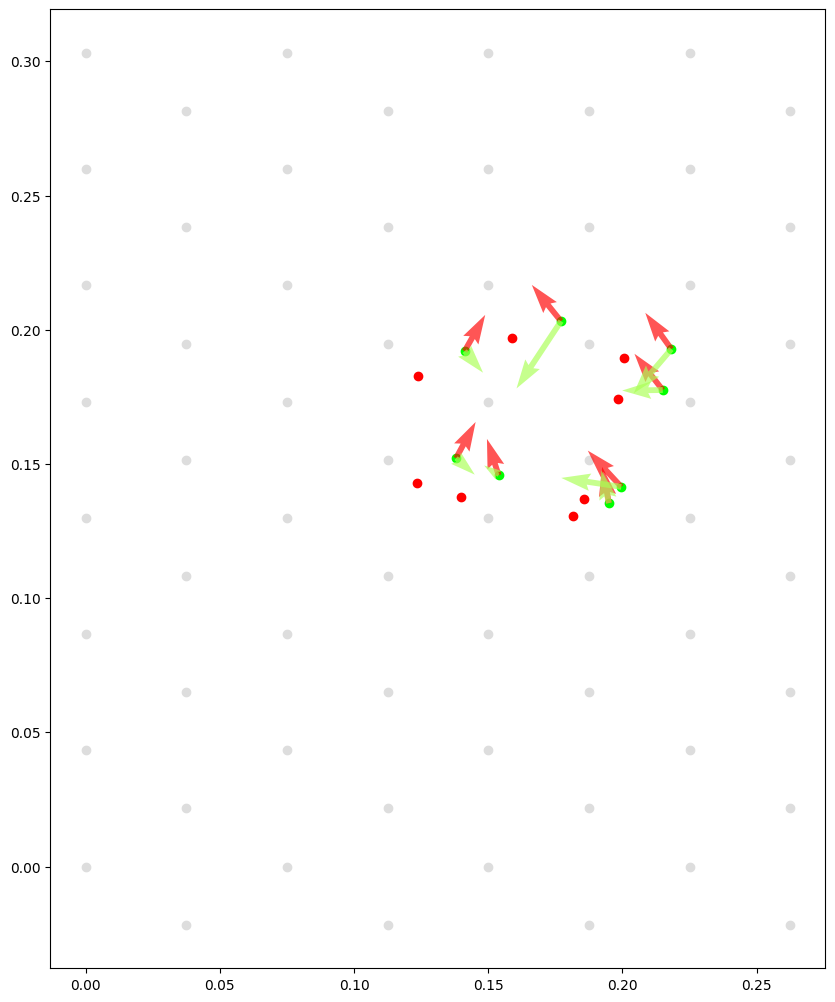

9


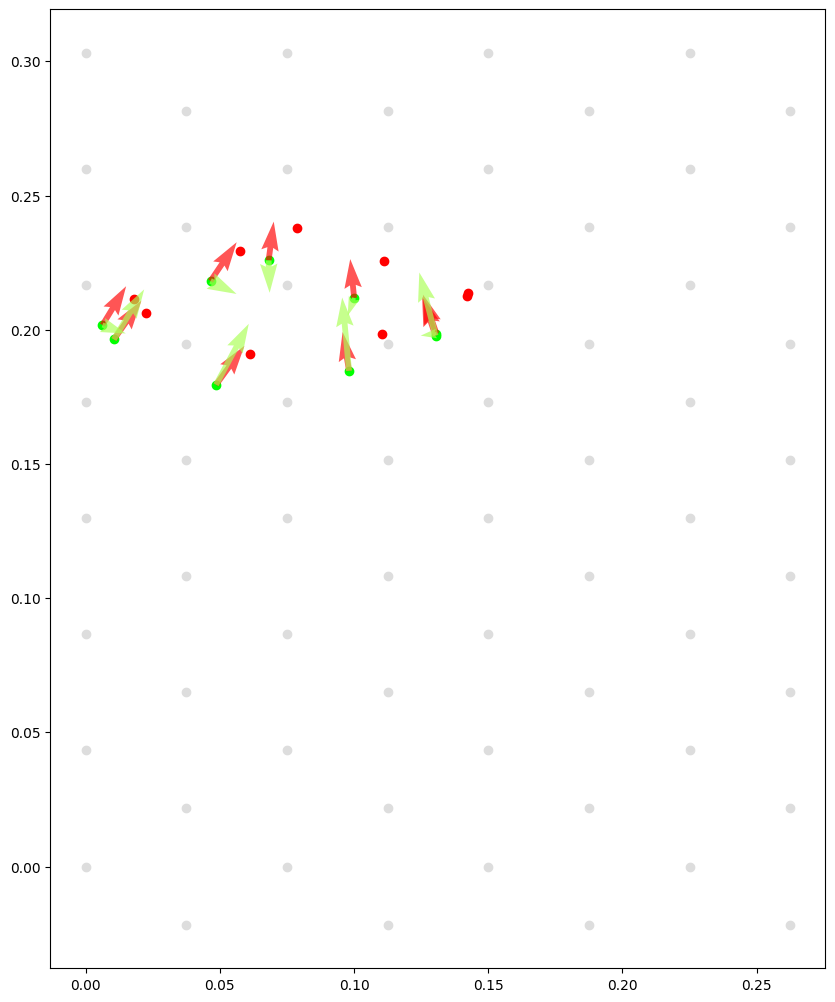

7


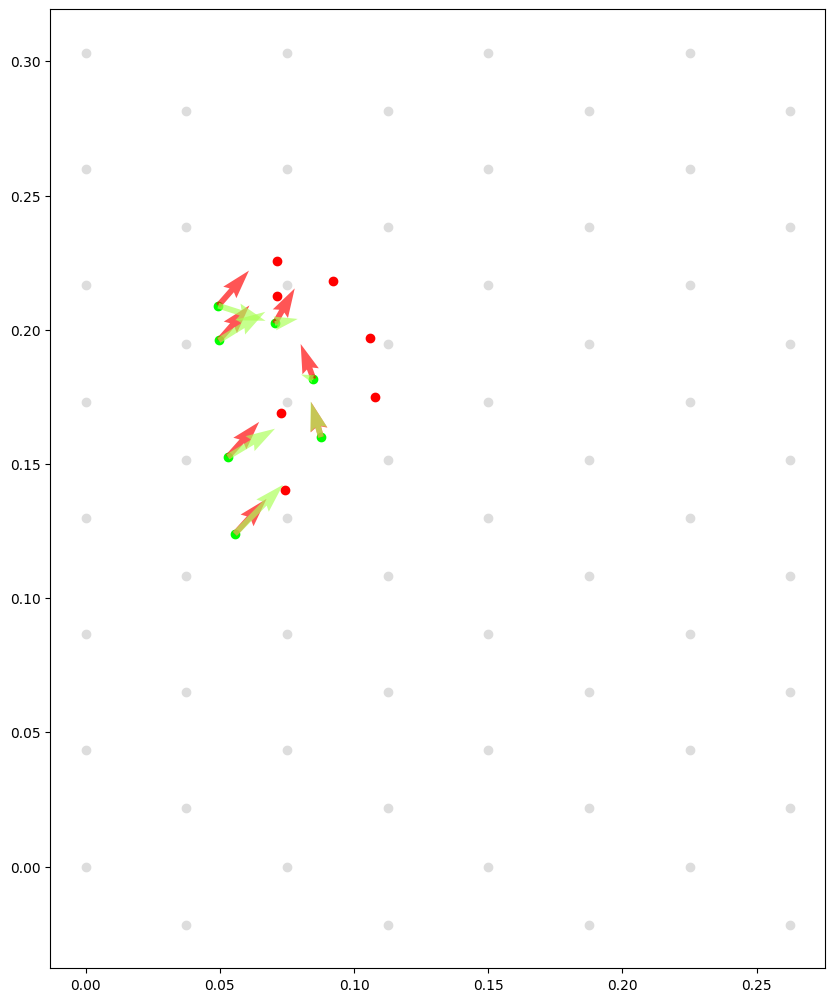

ValueError: operands could not be broadcast together with shapes (8,2) (7,2) 

In [19]:
losses = []
for n, (state, action, action_gt, pos) in enumerate(zip(statesss, actionsss, actions_gt, possss)):
    state, action, action_gt, pos = state, action, action_gt, pos
    pos = pos.detach().cpu().numpy()
    acts = action.detach().cpu().numpy()
    acts_gt = action_gt.detach().cpu().numpy()
    state = state.detach().cpu().numpy()


    # state = state_scaler.inverse_transform(state)
    # acts = action_scaler.inverse_transform(acts)
    # acts_gt = action_scaler.inverse_transform(act_gt)

    for n, idx in enumerate(range(state.shape[0])):
    # idx = 0
        po = pos[idx]
        n_agents = len([p for p in po if p != 0])
        r_poses = kdtree_positions_world[po[:n_agents]]
        init_pts = state[idx][:n_agents,:2] + r_poses
        goal_bd_pts = state[idx][:n_agents,2:4] + r_poses
        act_grsp = state[idx][:n_agents,4:6]
        act = acts[idx]
        act_gt = acts_gt[idx, :n_agents]
        r_poses2 = r_poses + act_grsp

        losses.append(np.linalg.norm(act - act_gt))
        # acts = acts/np.linalg.norm(acts, axis=1).reshape(-1, 1)
        # act_gt = act_gt/np.linalg.norm(act_gt, axis=1).reshape(-1, 1)


        print(n_agents)
        plt.figure(figsize=(10,17.78))
        plt.scatter(kdtree_positions_world[:, 0], kdtree_positions_world[:, 1], c='#ddddddff')
        plt.scatter(init_pts[:, 0], init_pts[:, 1], c = '#00ff00ff')
        plt.scatter(goal_bd_pts[:, 0], goal_bd_pts[:, 1], c='red')

        # plt.quiver(r_poses[:, 0], r_poses[:, 1], act_grsp[:, 0], act_grsp[:, 1], color='#0000ff88')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act[:, 0], act[:, 1], color='#ff0000aa')
        plt.quiver(r_poses2[:, 0], r_poses2[:, 1], act_gt[:, 0], act_gt[:, 1], color='#aaff55aa')

        plt.gca().set_aspect('equal')
        plt.show()
        if n%30 == 0:
            break

In [ ]:
import numpy as np
import plotly.graph_objs as go
import plotly.figure_factory as ff

# Dummy function to simulate pretrained diffusion model
def diffusion_model(state):
    # Generates dummy actions conditioned on state
    return np.sin(state) + np.random.normal(scale=0.1, size=state.shape)

# Dummy function to compute the score function for the actions
def compute_score_function(actions):
    # Compute a dummy score function for visualization
    return np.gradient(actions, axis=0)

# Example data
num_samples = 100
state_dim = 3  # Example state dimension
states = np.linspace(-10, 10, num_samples).reshape(-1, 1) * np.ones((1, state_dim))

# Generate actions using the pretrained diffusion model
actions = diffusion_model(states)

# Compute the score function for the actions
score_function = compute_score_function(actions)

# Create a 3D plot of the score function
fig = go.Figure()

for i in range(state_dim):
    # Add traces for each dimension of the score function
    fig.add_trace(go.Scatter3d(
        x=states[:, 0],
        y=actions[:, i],
        z=score_function[:, i],
        mode='lines',
        name=f'Score Dimension {i+1}',
        line=dict(width=4)
    ))

# Customize the layout for better presentation
fig.update_layout(
    title='3D Visualization of the Score Function',
    scene=dict(
        xaxis_title='State',
        yaxis_title='Action',
        zaxis_title='Score'
    ),
    legend=dict(x=0.1, y=0.9)
)

# Show the plot
fig.show()


In [ ]:
# BYOL for learning robot idx embeddings
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

class IntegerEmbeddingModel(nn.Module):
    def __init__(self, num_embeddings, embedding_dim):
        super(IntegerEmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)

    def forward(self, x):
        return self.embedding(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# Model parameters
num_embeddings = 64  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = IntegerEmbeddingModel(num_embeddings, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Generate a batch of integer indices
    # In a real scenario, you might want to sample these more carefully
    indices = torch.randint(0, num_embeddings, (batch_size,))  # Batch size of 32

    # "View 1" is just the embedding
    embedding1 = model(indices)

    # "View 2" could be the embedding of the next integer, simulating a simple 'transformation'
    # This is a simplistic approach; consider more sophisticated methods for your task
    indices_2 = (indices + torch.randint(0, num_embeddings, (batch_size,))) % num_embeddings  # Ensure it wraps around at the max integer
    embedding2 = model(indices_2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
n_values = torch.arange(64)
a = model(n_values)
b = model(n_values)
cos_sim = torch.nn.CosineSimilarity(dim=0)

cos_sim_matrix = torch.zeros(64, 64)

for i in range(64):
    for j in range(64):
        cos_sim_matrix[i, j] = cos_sim(a[i], b[j])


# Plotting the heatmap
plt.figure(figsize=(8, 6))
plt.title("Heatmap of Cosine Similarity")
plt.imshow(cos_sim_matrix.detach().numpy(), cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.show()

In [ ]:
a = torch.randint(0, 64, (32,10))
op = model(a)
op.shape

In [ ]:
class ShapeEmbeddingModel(nn.Module):
    def __init__(self, num_bd_pts, hidden_dim, embed_dim):
        super(ShapeEmbeddingModel, self).__init__()
        self.layer1 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer2 = nn.Linear(num_bd_pts, hidden_dim)
        self.layer3 = nn.Linear(num_bd_pts, embed_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

def contrastive_loss(embedding1, embedding2):
    # Simple contrastive loss that encourages the model to make embeddings similar
    # You might want to experiment with more sophisticated losses
    return ((embedding1 - embedding2)**2).mean()

# def triplet_loss(anchor, positive, negative, margin=1.0):
#     distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, keepdim=True)
#     distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, keepdim=True)
#     losses = torch.relu(distance_positive - distance_negative + margin)
#     return losses.mean()


bd_pts_dict = pkl.load(open('../../config/assets/obj_props.pkl', 'rb'))
bd_pts = []
for name in bd_pts_dict.keys():
    bd_pts.append(bd_pts_dict[name][1].reshape(512,))

bd_pts = torch.tensor(bd_pts).float()

In [ ]:
# Model parameters
num_objects = 9
num_bd_pts = 256*2  # For integers 0-63
embedding_dim = 128  # Size of the embedding vector
batch_size = 64

# Model, optimizer, and loss function
model = ShapeEmbeddingModel(num_bd_pts, 512, embedding_dim)
optimizer = optim.Adam(model.parameters(), lr=0.001)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2, eps=1e-6)

# Training loop
num_epochs = 10000
losses = []
for epoch in range(num_epochs):
    optimizer.zero_grad()

    indices = torch.randint(0, num_objects, (batch_size,))
    input1 = torch.index_select(data, 0, indices)
    embedding1 = model(input1)

    indices_2 = (indices + torch.randint(0, num_objects, (batch_size,))) % num_objects  # Ensure it wraps around at the max integer
    input2 = torch.index_select(data, 0, indices_2)
    embedding2 = model(input2)

    # Compute the loss and update the model
    # loss = contrastive_loss(embedding1, embedding2)
    loss = triplet_loss(embedding1, embedding1, embedding2)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()
